# Week 5 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic and influence networks. We begin by introducing you to some straightforward approaches to network analysis. We then begin to illustrate them with word networks that we can analyze to understand the structure of how words connect with one another, and the dynamics of how their meanings flow through a discursive system. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify them). Rendering words linked as a network or discrete topology allows us to take advantage of the network analysis metrics like centrality and community.

Texts also represent moves in a social game, and we can analyze the interchange of words and phrases within them in order to understand more about the relationships between people, groups and organizations that interact with one another. For example, who influences whom? And in a singular conversation--like a discussion of tweets on comments in Facebook--or over vast stretches of time (e.g., How much was Kant influenced by Aristotle? by Plato? Was _Chinatown_ director Robert Towne influenced by Sophocles?) We will do this by extracting conversational moves from text. But note that the similarity measures from last week's homework can also be used to represent a matrix of similarities--and potential influences--from one document to another. Rendering social actors or documentary events (e.g., a book) linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, and sophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity of social relations. Moreover, we can link explicit social interactions (e.g., "friendship" on Facebook, coupling in a romantic relationship, etc.) with semantic networks to better make sense of how pepole (inter)act in the world. 

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

In [9]:
g.nodes[2]['name'] = 'dog'

In [10]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [11]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [12]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

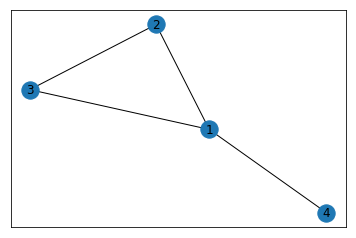

In [13]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here with a word semantic network.

First let's load some data: the Grimmer Senate press release corpus:

In [14]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [15]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

Let's begin by looking at words that co-occur in the same sentences:

In [16]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 press releases.

In [17]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Total number of vertices:

In [18]:
len(g.nodes)

4933

Total number of edges:

In [19]:
len(g.edges)

182267

A part of the adjacency matrix of cleaned word by press releases:

In [20]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[ 4.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  4.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2., 36.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [21]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [22]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [23]:
import sklearn.feature_extraction
# in case we get a module not found error

In [24]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [25]:
senVects_incidence.shape

(100, 4924)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [26]:
g_2mode = nx.Graph()

#define all the nodes

# word nodes are added with name (the word itself)
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
# document nodes are added with only the index
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [27]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 5024
Number of edges: 21256
Average degree:   8.4618


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

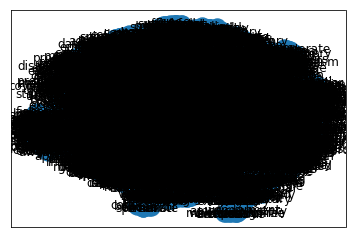

In [28]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [29]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [30]:
gDoc = contractNetwork(g_2mode, 'doc')

# notes: use doc-word two-mode network to extract doc-doc one-mode network. 
# the new network represent the number of words that any to documents share. 

Let's first take a look at the document-to-document network:

In [31]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

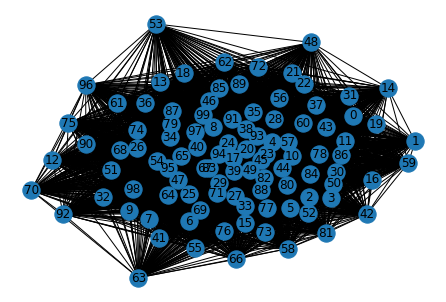

In [32]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

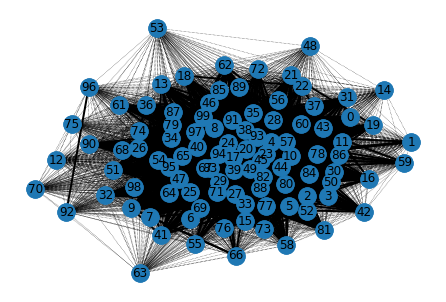

In [33]:
#notes: arg data=True means to return a three-tuple, the two end-nodes of an edge and the data stored on this edge. 
#the data is a dictionary, so the tuple is: tuple(n1, n2, {'weight': int})
#documentation: https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.edges.html?highlight=graph%20edges#networkx.Graph.edges

wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)]) 
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
# notes: first, draw the nodes, and the edges in edgesLow with thinner width. 
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
# notes: second, draw the edges in edgesHigh, with thicker width. 
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [34]:
#notes: the network is doc-doc network, so 63 is the 63th document. 
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


In [35]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [36]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4924
Number of edges: 2161481
Average degree: 877.9370


First, let's reduce the number of words to a manageable size.

In [37]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.7461009372740264

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 25, then drop all the isolates. You are recommended to play with the weight here to see how the graph might look different.

In [38]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

In [39]:
len(g)

4933

In [40]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [41]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [42]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
        
# notes: 
# connected_component_subgraphs 
#     - community
#     - cliques

In [43]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 154
Number of edges: 431
Average degree:   5.5974


A bit smaller now, Now, let's visualize it: 

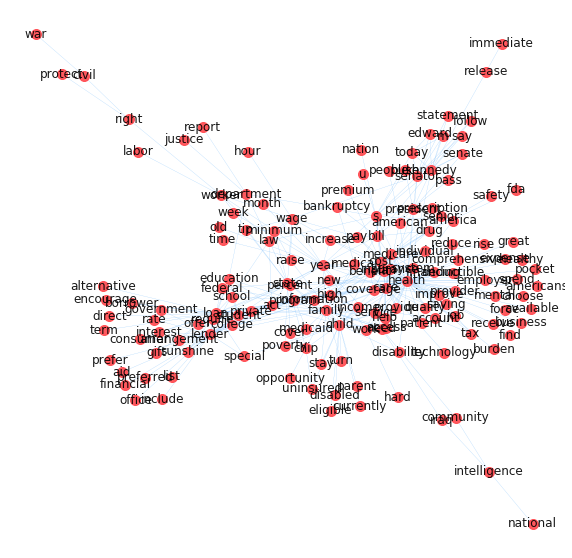

In [44]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [45]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

Let us use this oppurtunity to introduce a concept of finding communities in graphs: a popular one is the modularity measure, introduced in: Clauset, A., Newman, M. E., & Moore, C. “Finding community structure in very large networks.” Physical Review E 70(6), 2004.

networkx implements this through the above method. It yields sets of nodes, one for each community.

In [46]:
c

[frozenset({'access',
            'account',
            'act',
            'aid',
            'alternative',
            'america',
            'american',
            'americans',
            'arrangement',
            'available',
            'bankruptcy',
            'benefit',
            'bill',
            'borrower',
            'burden',
            'bush',
            'business',
            'care',
            'child',
            'chip',
            'choose',
            'civil',
            'college',
            'community',
            'comprehensive',
            'consumer',
            'cost',
            'cover',
            'coverage',
            'currently',
            'deductible',
            'department',
            'direct',
            'disability',
            'disabled',
            'drug',
            'education',
            'edward',
            'eligible',
            'employer',
            'encourage',
            'expense',
            'family',
   

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score). Note that for this case we get the same graph; this is just to demonstrate the different kinds of node dropping and graph changes we can do.

In [47]:
giant = nx.Graph(giant)

In [48]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 154
Number of edges: 431
Average degree:   5.5974


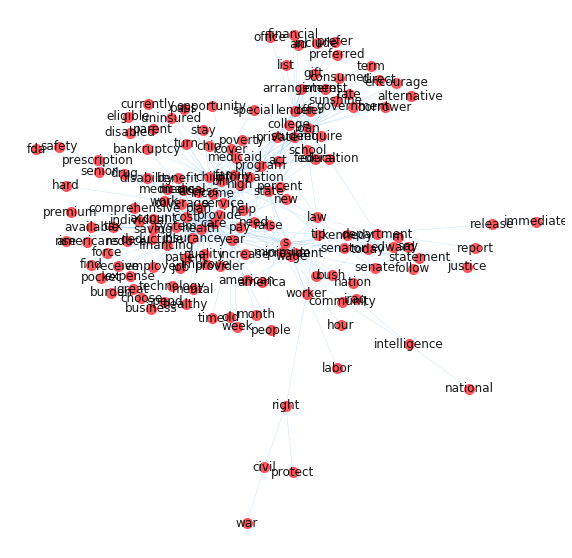

In [49]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [50]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

loan, lender, student, college, family, act


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [51]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 11
Average degree:   4.4000


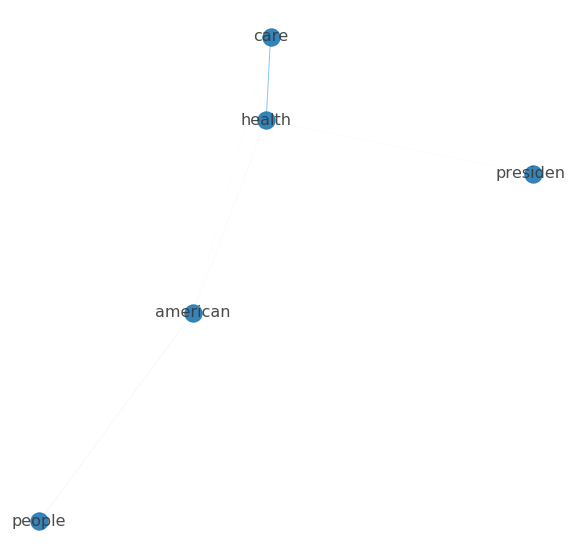

In [52]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [53]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [54]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: Graph
Number of nodes: 149
Number of edges: 419
Average degree:   5.6242


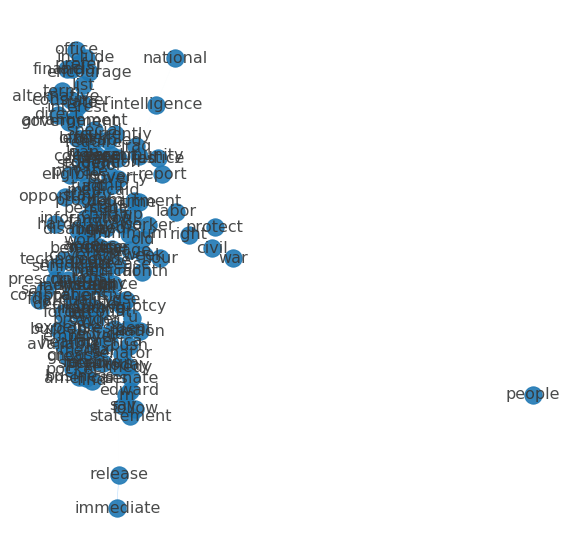

In [55]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

Answers to the questions and findings are written inside cells as comments

In [395]:
# Load the corpus: this is an incomplete corpus of the text descriptions of the cellections 
# in the Art Insitute of Chicago
# The files starting with "(1," indicates the spidering was interupted by the website server
# The updated spider program is currently re-spidering the missing data to complete the corpus. 
art_chicago_info_list = []
repo = '../museum/description_metadata_in-one-file/'

for filename in os.listdir(repo): 
    if 'artwork_description_metadata' in filename and not filename.startswith('.'): 
        print(filename)
        art_chicago_info_list.append(pandas.read_csv(repo + '/' + filename, index_col=False))

art_chicago = pandas.concat(art_chicago_info_list)

0_artwork_description_metadata_1450_1500.csv
(1, 830)_artwork_description_metadata_800_850.csv
0_artwork_description_metadata_650_700.csv
0_artwork_description_metadata_700_750.csv
0_artwork_description_metadata_1650_1700.csv
(1, 1087)_artwork_description_metadata_1100_1150.csv
0_artwork_description_metadata_1300_1350.csv
0_artwork_description_metadata_750_800.csv
0_artwork_description_metadata_1400_1450.csv
0_artwork_description_metadata_1750_1800.csv
0_artwork_description_metadata_1600_1650.csv
(1, 941)_artwork_description_metadata_950_1000.csv
(1, 1087)_artwork_description_metadata_1050_1100.csv
(1, 892)_artwork_description_metadata_850_900.csv
(1, 941)_artwork_description_metadata_900_950.csv
(1, 941)_artwork_description_metadata_1000_1050.csv
0_artwork_description_metadata_1550_1600.csv
(1, 1180)_artwork_description_metadata_1150_1200.csv
0_artwork_description_metadata_1800_1850.csv
(1, 1180)_artwork_description_metadata_1200_1250.csv
0_artwork_description_metadata_1500_1550.csv
0

In [396]:
# Organize the records in the corpus by sorting on index
# index is the number of the artwork
art_chicago = art_chicago.sort_values(by=['index']).reset_index(drop=True)
art_chicago.head(10)

artwork_title  \
0  Fragment of a Necklace, 3rd century AD, Ancien...   
1      Auvers, Panoramic View, 1873/75, Paul Cézanne   
2  Stamnos (Mixing Jar), about 450 BC, Chicago Pa...   
3                       Girl with Cat, 1937, Balthus   
4                       Girl with Cat, 1937, Balthus   
5                       Girl with Cat, 1937, Balthus   
6                       Girl with Cat, 1937, Balthus   
7                       Girl with Cat, 1937, Balthus   
8  Statuette of Osiris, Late Period, Dynasty 26–3...   
9  Are They Thinking about the Grape? (Pensent-il...   

                                    description_text  index  \
0  The stylized bird forms seen here in repeating...  654.0   
1  Paul Cézanne painted this work during his firs...  657.0   
2  This refined Athenian stamnos (pl. stamnoi) wa...  659.0   
3  Balthus’s legendary secretiveness has inhibite...  664.0   
4  Most literature on this painting considers alt...  664.0   
5  The genre of salacious images of women with wh...  664.0   
6  The setting of Girl with Cat has many of the t...  664.0   
7  — Entry, Dawn Ades, Surrealist Art: The Lindy ...  664.0   
8  Here Osiris is shown enveloped in his mummy sh...  665.0   
9  Although he painted a broad range of subjects ...  666.0   

                                            metadata  \
0  Culture\nAncient Roman\nTitle\nFragment of a N...   
1  Artist\nPaul Cézanne\nTitle\nAuvers, Panoramic...   
2  Artist\nChicago Painter (Painter)\nTitle\nStam...   
3  Artist\nBalthus\nTitle\nGirl with Cat\nOrigin\...   
4  Artist\nBalthus\nTitle\nGirl with Cat\nOrigin\...   
5  Artist\nBalthus\nTitle\nGirl with Cat\nOrigin\...   
6  Artist\nBalthus\nTitle\nGirl with Cat\nOrigin\...   
7  Artist\nBalthus\nTitle\nGirl with Cat\nOrigin\...   
8  Culture\nAncient Egyptian\nTitle\nStatuette of...   
9  Artist\nFrançois Boucher\nTitle\nAre They Thin...   

                                                 url  
0  https://www.artic.edu/artworks/845/fragment-of...  
1  https://www.artic.edu/artworks/14556/auvers-pa...  
2  https://www.artic.edu/artworks/177/stamnos-mix...  
3  https://www.artic.edu/artworks/117241/girl-wit...  
4  https://www.artic.edu/artworks/117241/girl-wit...  
5  https://www.artic.edu/artworks/117241/girl-wit...  
6  https://www.artic.edu/artworks/117241/girl-wit...  
7  https://www.artic.edu/artworks/117241/girl-wit...  
8  https://www.artic.edu/artworks/617/statuette-o...  
9  https://www.artic.edu/artworks/44742/are-they-...

In [397]:
# merge multiple paragraphs in one description into one description chunk
# then we can perform artwork - artwork network

art_chicago_merge_description_dict = dict()
for row_index, row in art_chicago.iterrows(): 
    if row['index'] in art_chicago_merge_description_dict:
        art_chicago_merge_description_dict[row['index']] += row['description_text']
    else: 
        art_chicago_merge_description_dict[row['index']] = row['description_text']

new_art_chicago_df_list = []
art_chicago_index_list = []
for row_index, row in art_chicago.iterrows(): 
    if not row['index'] in art_chicago_index_list: 
        thisrow = pandas.DataFrame(data={'artwork_title': row['artwork_title'], 
                                     'description_text_merge': art_chicago_merge_description_dict[row['index']], 
                                     'metadata': row['metadata'], 
                                     'url': row['url']}, index=[row['index']])
        art_chicago_index_list.append(row['index'])
        new_art_chicago_df_list.append(thisrow)

art_chicago = pandas.concat(new_art_chicago_df_list)
  

In [398]:
# Tokenize 
art_chicago['tokenized_sents'] = art_chicago['description_text_merge'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
art_chicago['normalized_sents'] = art_chicago['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [31]:
art_chicago.head(3)

artwork_title  \
654.0  Fragment of a Necklace, 3rd century AD, Ancien...   
657.0      Auvers, Panoramic View, 1873/75, Paul Cézanne   
659.0  Stamnos (Mixing Jar), about 450 BC, Chicago Pa...   

                                  description_text_merge  \
654.0  The stylized bird forms seen here in repeating...   
657.0  Paul Cézanne painted this work during his firs...   
659.0  This refined Athenian stamnos (pl. stamnoi) wa...   

                                                metadata  \
654.0  Culture\nAncient Roman\nTitle\nFragment of a N...   
657.0  Artist\nPaul Cézanne\nTitle\nAuvers, Panoramic...   
659.0  Artist\nChicago Painter (Painter)\nTitle\nStam...   

                                                     url  \
654.0  https://www.artic.edu/artworks/845/fragment-of...   
657.0  https://www.artic.edu/artworks/14556/auvers-pa...   
659.0  https://www.artic.edu/artworks/177/stamnos-mix...   

                                         tokenized_sents  \
654.0  [[The, stylized, bird, forms, seen, here, in, ...   
657.0  [[Paul, Cézanne, painted, this, work, during, ...   
659.0  [[This, refined, Athenian, stamnos, pl, stamno...   

                                        normalized_sents  
654.0  [[stylize, bird, form, see, repeat, pair, popu...  
657.0  [[paul, cézanne, paint, work, prolonged, stay,...  
659.0  [[refined, athenian, stamno, pl, stamnoi, mix,...

In [32]:
# Define a function that calculate co-occur in the same sentence
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [33]:
# Build graphs starting with a two-mode network. 
# Now build a artwork-word frequency matrix. 

In [34]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [35]:
import sklearn.feature_extraction
# in case we get a module not found error


art_Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
art_Vects_incidence = art_Vectorizer.fit_transform(art_chicago['description_text_merge'])

In [36]:
art_Vects_incidence.shape

# 419 artworks * 7731 words

(419, 7731)

In [37]:
# Turn the incidenc ematrix into a network. 
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((art_Vectorizer.get_feature_names()[i] for i in range(art_Vects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(art_Vects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, art_Vectorizer.get_feature_names()[w], {'weight' : art_Vects_incidence[d, w]}) for d, w in zip(*art_Vects_incidence.nonzero())))

In [38]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 8150
Number of edges: 26662
Average degree:   6.5428


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


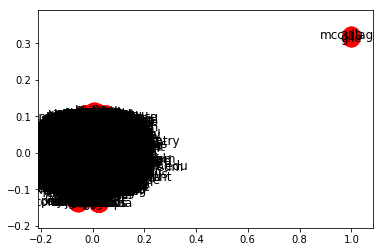

In [39]:
nx.draw_networkx(g_2mode)

In [40]:
# We want to see what the outlier is about. 
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [41]:
giant = min(connected_component_subgraphs(g_2mode), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 2
Average degree:   1.3333


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


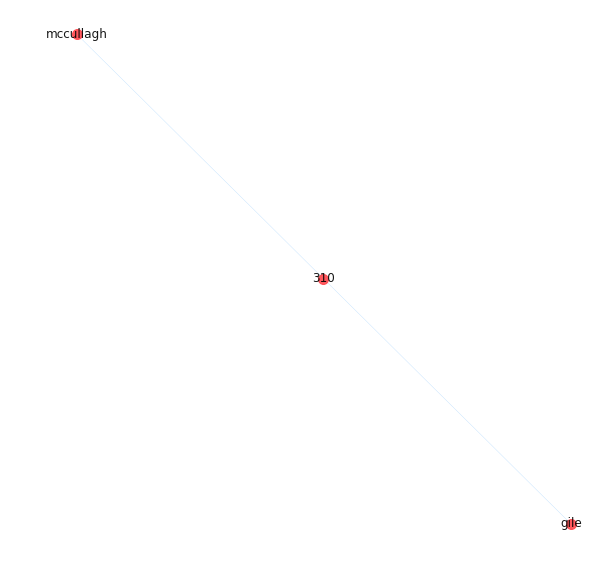

In [42]:
# it is the 310-th artwork that is so distinct
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [52]:
# Huh, it is a Catalogue raisonné, so it is so distinct. 
art_chicago.iloc[310]

artwork_title             Madonna and Child (recto), and Fragment of Wom...
description_text_merge                                McCullagh & Giles 518
metadata                  Artist\nLeonardo da Vinci\nTitle\nMadonna and ...
url                       https://www.artic.edu/artworks/54937/madonna-a...
tokenized_sents                                   [[McCullagh, Giles, 518]]
normalized_sents                                        [[mccullagh, gile]]
Name: 1529.0, dtype: object

In [50]:
# check the url
art_chicago.iloc[310]['url']

'https://www.artic.edu/artworks/54937/madonna-and-child-recto-and-fragment-of-woman-s-torso-verso'

In [54]:
%%html
<iframe src="https://www.artic.edu/artworks/54937/madonna-and-child-recto-and-fragment-of-woman-s-torso-verso" width="1200" height="1000"></iframe>

In [55]:
# Except for the outlier, all the rest are connected. 
giant = max(connected_component_subgraphs(g_2mode), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 8147
Number of edges: 26660
Average degree:   6.5447


In [56]:
# Define a function that transforms a two-mode network into two one-mode network
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [57]:
# get a one-mode network: artwork by artwork
# this network records the number of words shared by any two artworks
gDoc = contractNetwork(g_2mode, 'doc')

In [58]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 419
Number of edges: 73355
Average degree: 350.1432


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


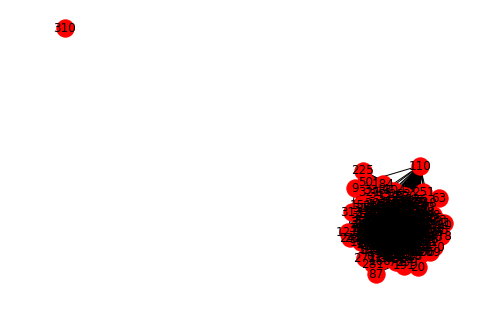

In [60]:
# construct a visualization
# how any two artworks are related to each other in terms of description language
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying


# Again, 310 is so distinct, we have seen the reason. 

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


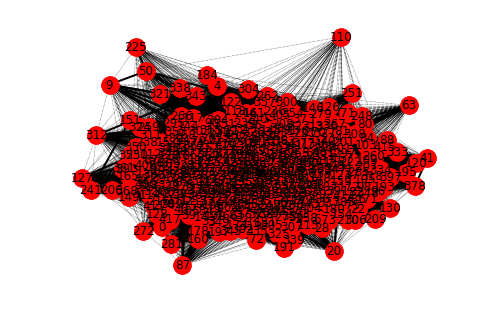

In [66]:
# Before drawing another graph, we remove 310. 
gDoc.remove_node(310)

# draw the graph with high and low weight edges distinguished:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [70]:
# Let's first drop all the edges with weight below 25, then drop all the isolates.
gDoc.remove_edges_from([(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= 25])
gDoc.remove_nodes_from(list(nx.isolates(gDoc)))

# After dropping, find the network with the most connected-component again
giant = max(connected_component_subgraphs(gDoc), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 21
Number of edges: 69
Average degree:   6.5714


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


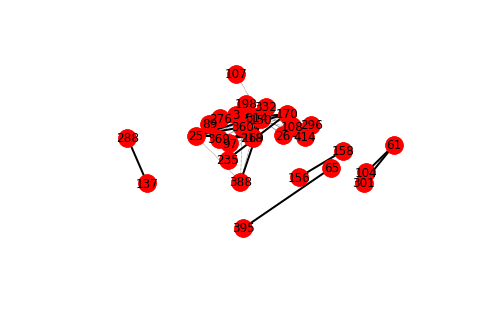

In [71]:
# again, draw the graph with high and low weight edges distinguished:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


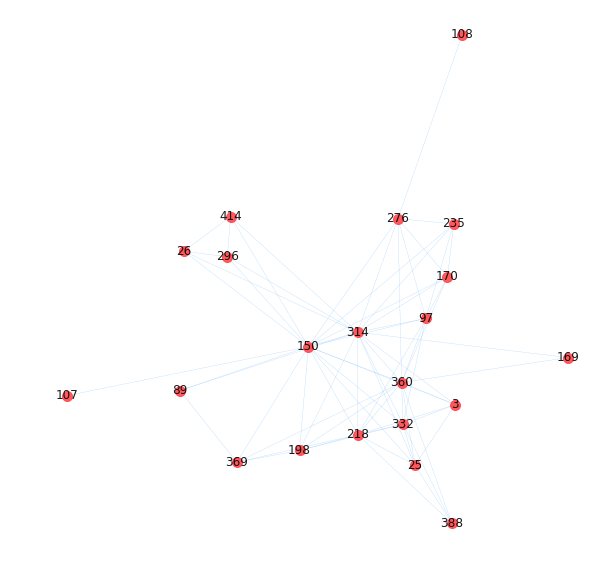

In [72]:
# draw the network with the most connected-component again
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [552]:
# 314 seems to be a "synthesis", which is the least distinct artwork. 
# see what it is: 

# check the url
art_chicago.iloc[314]

artwork_title       Portrait of a Man with a Pink, 1500/10, Quenti...
description_text    In the early 16th century, Antwerp experienced...
index                                                             939
metadata            Artist\nQuentin Massys\nTitle\nPortrait of a M...
url                 https://www.artic.edu/artworks/864/portrait-of...
metadata_split      [Artist, Quentin Massys, Title, Portrait of a ...
artist_name                                            Quentin Massys
Name: 15, dtype: object

In [76]:
%%html
<iframe src="https://www.artic.edu/artworks/114932/upraised-right-hand-with-palm-facing-outward-study-for-saint-peter" width="1200" height="1000"></iframe>

In [131]:
# WORD - WORD network

# turn it around and look at the word-to-word network by documents.
g = wordCooccurrence(art_chicago['normalized_sents'].sum())

In [132]:
# drop all the edges with weight below 15, then drop all the isolates. 

g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 15])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [133]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 25
Number of edges: 39
Average degree:   3.1200


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


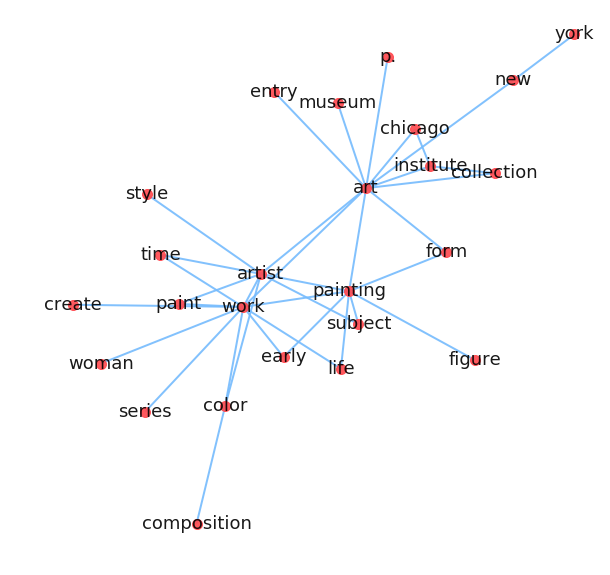

In [134]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue', 
       font_size=18) #Getting labels is a bit annoying


# The result is reasonable. 
# New is linked to York, we might have better use other tokinzation method like POS or NER. 

Name: 
Type: Graph
Number of nodes: 316
Number of edges: 816
Average degree:   5.1646


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


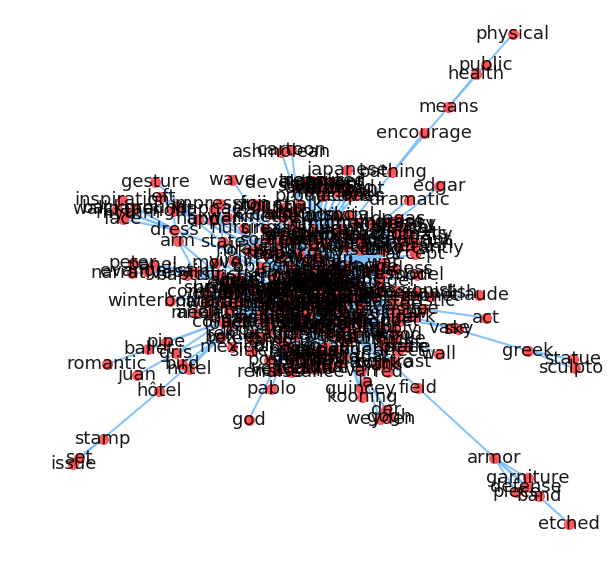

In [143]:
# We do the process again and drop less words
g = wordCooccurrence(art_chicago['normalized_sents'].sum())

g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 5])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue', 
       font_size=18) #Getting labels is a bit annoying

In [144]:
# finding communities in graphs

from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))
c

[frozenset({'15th',
            '16th',
            '19th',
            '20th',
            'abstract',
            'accept',
            'act',
            'active',
            'activity',
            'ade',
            'adulthood',
            'aesthetic',
            'african',
            'altarpiece',
            'american',
            'ancient',
            'appear',
            'apply',
            'arm',
            'art',
            'artist',
            'artistic',
            'ashmolean',
            'ballet',
            'baptist',
            'base',
            'bather',
            'begin',
            'bergman',
            'biblical',
            'bird',
            'black',
            'blue',
            'body',
            'box',
            'brushwork',
            'canvas',
            'career',
            'cartoon',
            'century',
            'ceramic',
            'chalk',
            'characteristic',
            'chicago',
            'child',
    

Name: 
Type: Graph
Number of nodes: 68
Number of edges: 94
Average degree:   2.7647


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


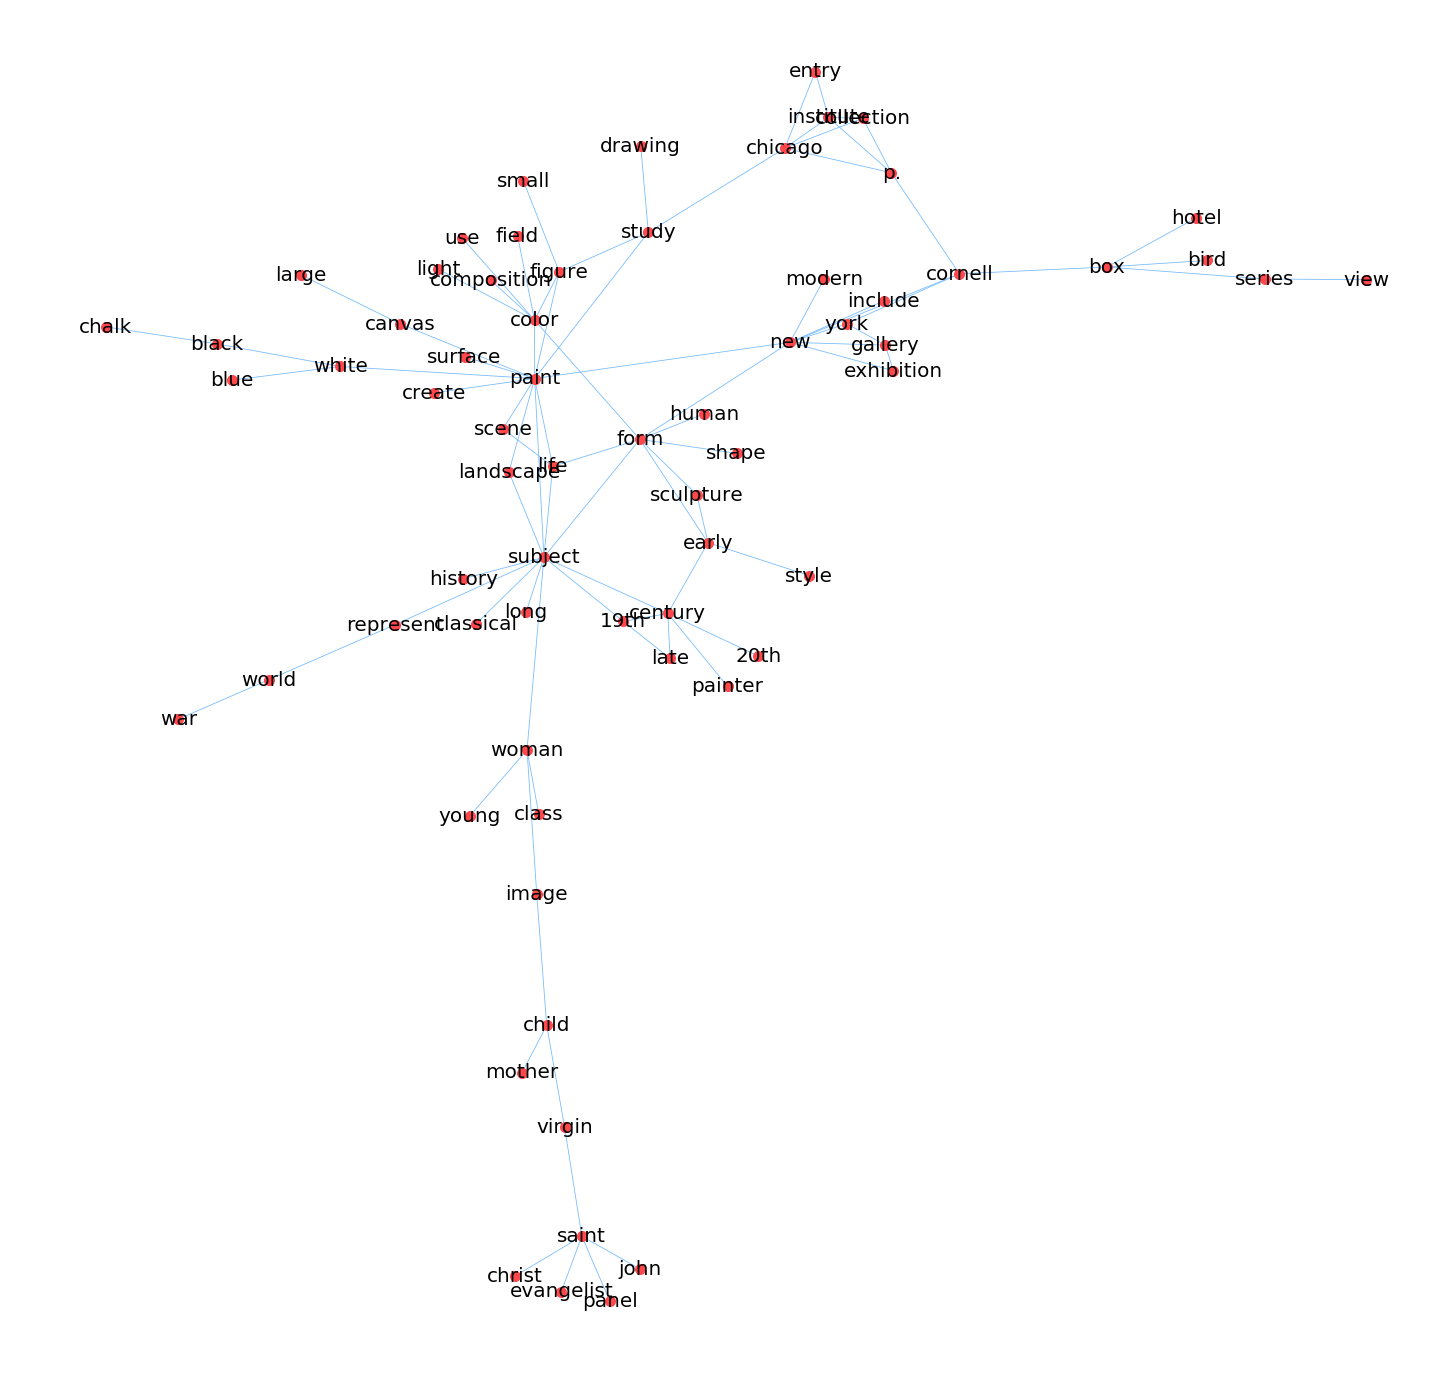

In [177]:
# also remove those words that show up in many documents <=8, >= 15

g = wordCooccurrence(art_chicago['normalized_sents'].sum())

g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 8])
g.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 20]) 
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (25,25))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=0.8, 
        alpha = 1, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue', 
       font_size=20) #Getting labels is a bit annoying


In [178]:
# find cliques, i.e. completely connected sets of nodes.

print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

institute, chicago, p., collection


Name: 
Type: Graph
Number of nodes: 316
Number of edges: 816
Average degree:   5.1646
Name: 
Type: Graph
Number of nodes: 622
Number of edges: 16141
Average degree:  51.9003


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


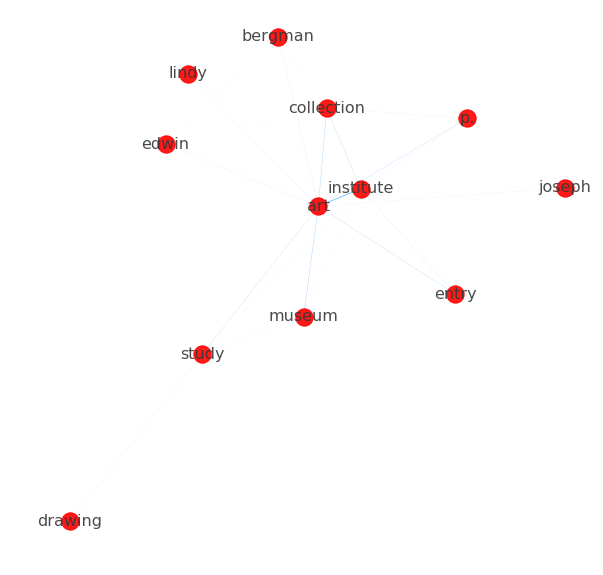

In [185]:
#  look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'chicago'.

# repeat the process and only remove isolated nodes

g = wordCooccurrence(art_chicago['normalized_sents'].sum())
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 5])


giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))


chicagoNeighbors = giant.neighbors('chicago')
g_chicago = giant.subgraph(chicagoNeighbors)
print(nx.info(g_american))


layout_amer = nx.spring_layout(g_chicago, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_chicago.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_chicago.edges(data = True)))
nx.draw(g_chicago, ax = ax, pos = layout_amer, labels = {n:n for n in g_chicago.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_chicago.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

Name: 
Type: Graph
Number of nodes: 67
Number of edges: 290
Average degree:   8.6567


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


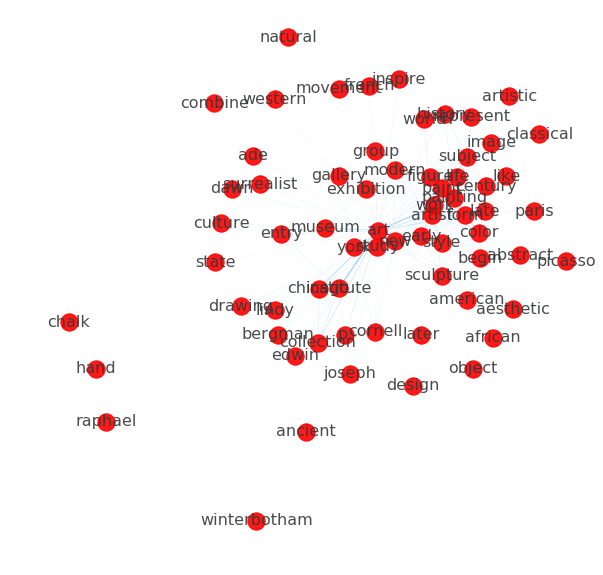

In [188]:
chicagoNeighbors = giant.neighbors('chicago')
chicagoNeighborsPlus1 = set(americanNeighbors)
for n in chicagoNeighbors:
    chicagoNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

g_chicago2 = giant.subgraph(chicagoNeighborsPlus1)
print(nx.info(g_chicago2))

layout_amer = nx.spring_layout(g_chicago2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_chicago2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_chicago2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_chicago2.edges(data = True)))
nx.draw(g_chicago2, ax = ax, pos = layout_amer, labels = {n:n for n in g_chicago2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_chicago2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [56]:
# returns a dictionary that stores the degree of centrality of each node
dcentralities = nx.degree_centrality(giant)

In [57]:
dcentralities['american']

0.0392156862745098

In [58]:
max(dcentralities.items(), key = lambda x : x[1])

('health', 0.43137254901960786)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

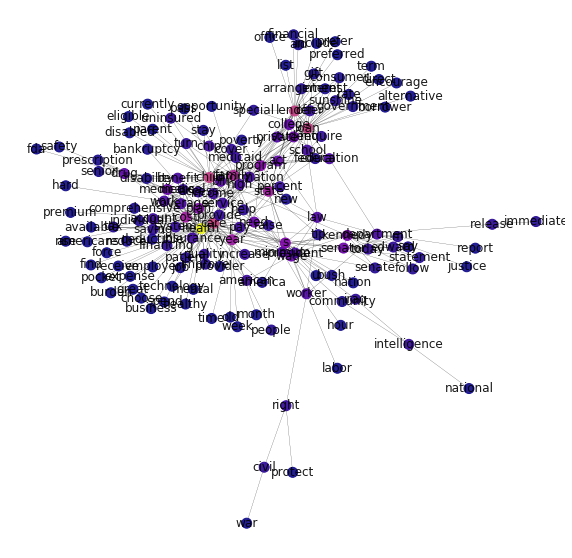

In [59]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

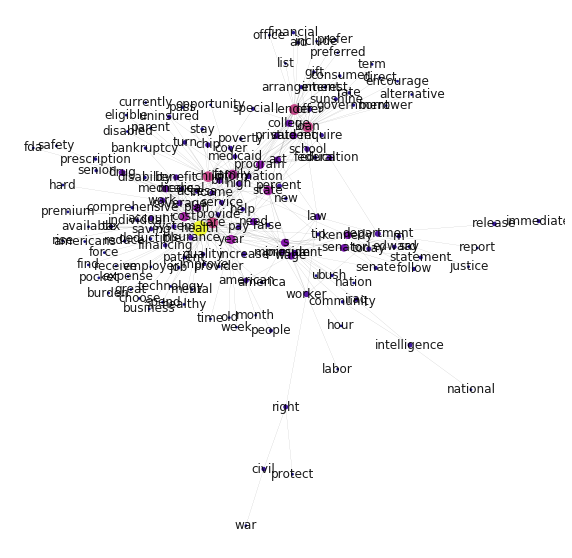

In [60]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

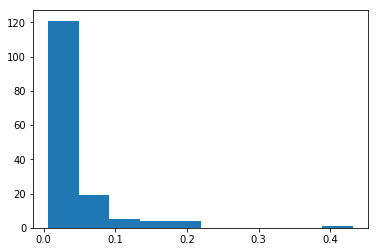

In [61]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [62]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.43137254901960786),
 ('care', 0.20915032679738563),
 ('loan', 0.20261437908496732),
 ('lender', 0.20261437908496732),
 ('child', 0.20261437908496732),
 ('family', 0.16993464052287582),
 ('state', 0.1503267973856209),
 ('cost', 0.1503267973856209),
 ('year', 0.14379084967320263),
 ('program', 0.11764705882352941)]

In [63]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('old', 0.006535947712418301),
 ('alternative', 0.006535947712418301),
 ('employer', 0.006535947712418301),
 ('time', 0.006535947712418301),
 ('protect', 0.006535947712418301),
 ('find', 0.006535947712418301),
 ('month', 0.006535947712418301),
 ('choose', 0.006535947712418301),
 ('burden', 0.006535947712418301),
 ('hour', 0.006535947712418301)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [64]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [65]:
centralities['american']

0.013071895424836602

In [66]:
max(centralities.items(), key = lambda x : x[1])

('health', 0.4470172111371691)

We can color and size the nodes by betweenness centrality:

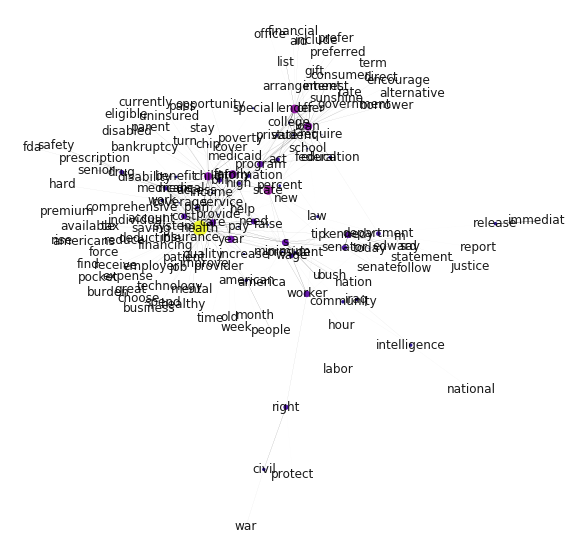

In [67]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

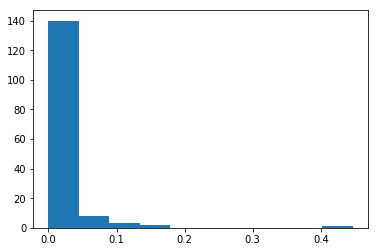

In [68]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [69]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.43137254901960786),
 ('care', 0.20915032679738563),
 ('loan', 0.20261437908496732),
 ('lender', 0.20261437908496732),
 ('child', 0.20261437908496732),
 ('family', 0.16993464052287582),
 ('state', 0.1503267973856209),
 ('cost', 0.1503267973856209),
 ('year', 0.14379084967320263),
 ('program', 0.11764705882352941)]

What are words lower down?

In [70]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('offer', 0.032679738562091505),
 ('cover', 0.032679738562091505),
 ('system', 0.032679738562091505),
 ('medicaid', 0.032679738562091505),
 ('raise', 0.026143790849673203),
 ('edward', 0.026143790849673203),
 ('m', 0.026143790849673203),
 ('help', 0.026143790849673203),
 ('iraq', 0.026143790849673203),
 ('financing', 0.026143790849673203)]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [71]:
centralities = nx.closeness_centrality(giant)

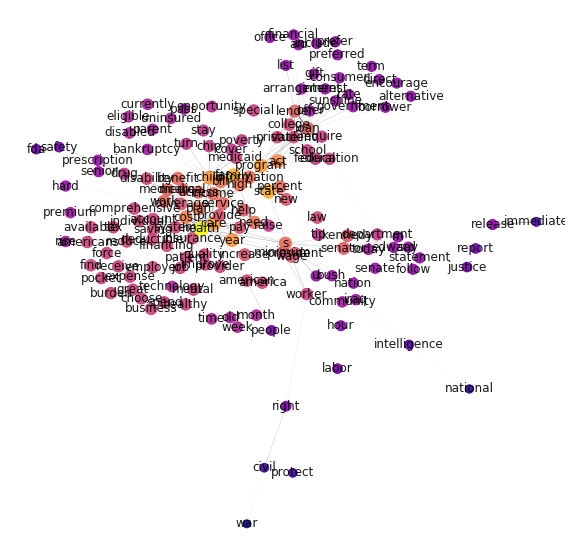

In [72]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [73]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.5464285714285714),
 ('family', 0.4811320754716981),
 ('state', 0.478125),
 ('care', 0.4636363636363636),
 ('program', 0.4622356495468278),
 ('child', 0.4540059347181009),
 ('year', 0.4526627218934911),
 ('act', 0.4421965317919075),
 ('cost', 0.4297752808988764),
 ('bill', 0.4214876033057851)]

In [74]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('report', 0.255),
 ('justice', 0.255),
 ('fda', 0.2528925619834711),
 ('safety', 0.2528925619834711),
 ('intelligence', 0.2311178247734139),
 ('immediate', 0.2191977077363897),
 ('civil', 0.20930232558139536),
 ('protect', 0.208731241473397),
 ('national', 0.18796068796068796),
 ('war', 0.17327293318233294)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [75]:
centralities = nx.eigenvector_centrality(giant)

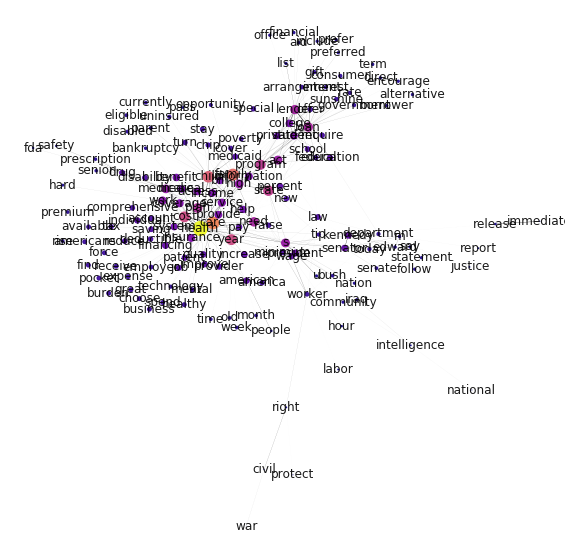

In [76]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

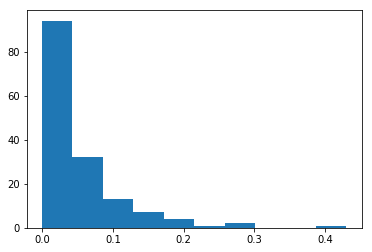

In [77]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [78]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.42995279031459827),
 ('care', 0.2947914920794643),
 ('family', 0.2603644408806845),
 ('child', 0.2382674519067325),
 ('year', 0.2079239618802662),
 ('cost', 0.20661666982150814),
 ('state', 0.18895034623150686),
 ('program', 0.17974768076823017),
 ('plan', 0.16286095340939513),
 ('loan', 0.15444867005457827)]

In [79]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('right', 0.002379491404427387),
 ('labor', 0.0021785593770077536),
 ('intelligence', 0.0018622546091151765),
 ('report', 0.0015865384548653968),
 ('justice', 0.0015865384548653968),
 ('immediate', 0.000447560413509399),
 ('civil', 0.00018917863089936015),
 ('protect', 0.00017430529656646003),
 ('national', 0.00013641034495485814),
 ('war', 1.385814528262875e-05)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [80]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [81]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 112
Average degree:   8.9600


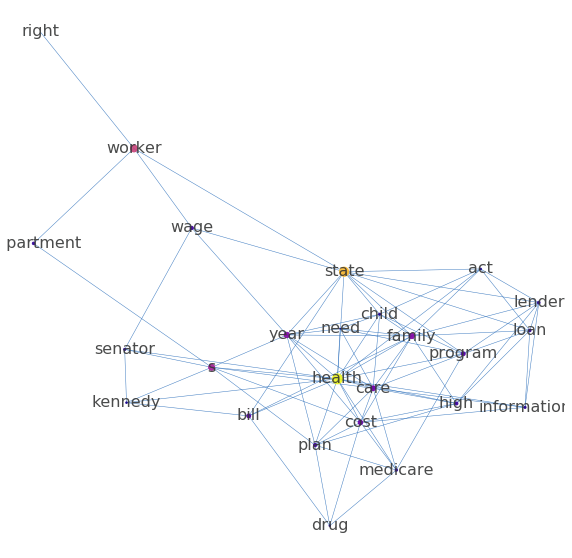

In [82]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [83]:
nx.density(giant)

0.03658433070197776

We can also calculate the average degree per node:

In [84]:
np.mean([v for w,v in nx.degree(giant)])

5.597402597402597

The diameter calculates the average distance between any two nodes in the network:

In [85]:
nx.diameter(giant)

9

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [189]:
# repeat the process and only remove isolated nodes and rare words

g = wordCooccurrence(art_chicago['normalized_sents'].sum())
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 5])


giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 316
Number of edges: 816
Average degree:   5.1646


In [ ]:
# degree of centrality

In [204]:
dcentralities = nx.degree_centrality(giant)

In [191]:
dcentralities['chicago']

0.0380952380952381

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


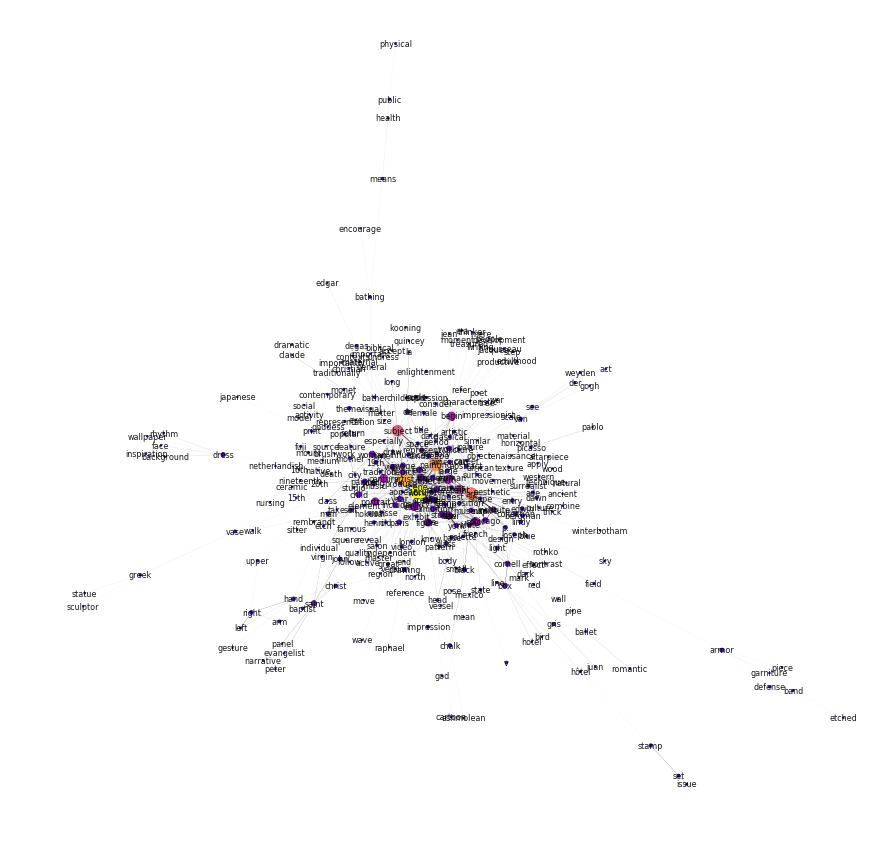

In [200]:
fig, ax = plt.subplots(figsize = (15,15))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + 1) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        font_size=8, 
        cmap = plt.get_cmap('plasma')) 

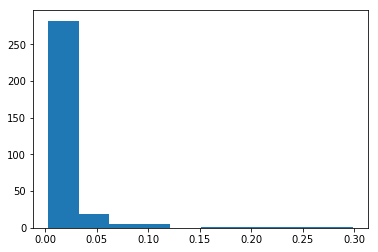

In [201]:
# The distrubution of degree centrality: 
plt.hist(list(dcentralities.values()))
plt.show()

In [202]:
# the top ten words in terms of degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.2984126984126984),
 ('artist', 0.24761904761904763),
 ('painting', 0.21587301587301588),
 ('art', 0.19682539682539682),
 ('subject', 0.1619047619047619),
 ('paint', 0.12063492063492064),
 ('begin', 0.09841269841269841),
 ('color', 0.09841269841269841),
 ('century', 0.09523809523809523),
 ('form', 0.09523809523809523)]

In [203]:
# the botom ten words in terms of degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('mean', 0.0031746031746031746),
 ('physical', 0.0031746031746031746),
 ('tree', 0.0031746031746031746),
 ('follow', 0.0031746031746031746),
 ('hotel', 0.0031746031746031746),
 ('nursing', 0.0031746031746031746),
 ('winterbotham', 0.0031746031746031746),
 ('pipe', 0.0031746031746031746),
 ('reference', 0.0031746031746031746),
 ('gesture', 0.0031746031746031746)]

In [ ]:
# betweenness centrality

In [205]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [206]:
centralities['chicago']

0.002903888749502329

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


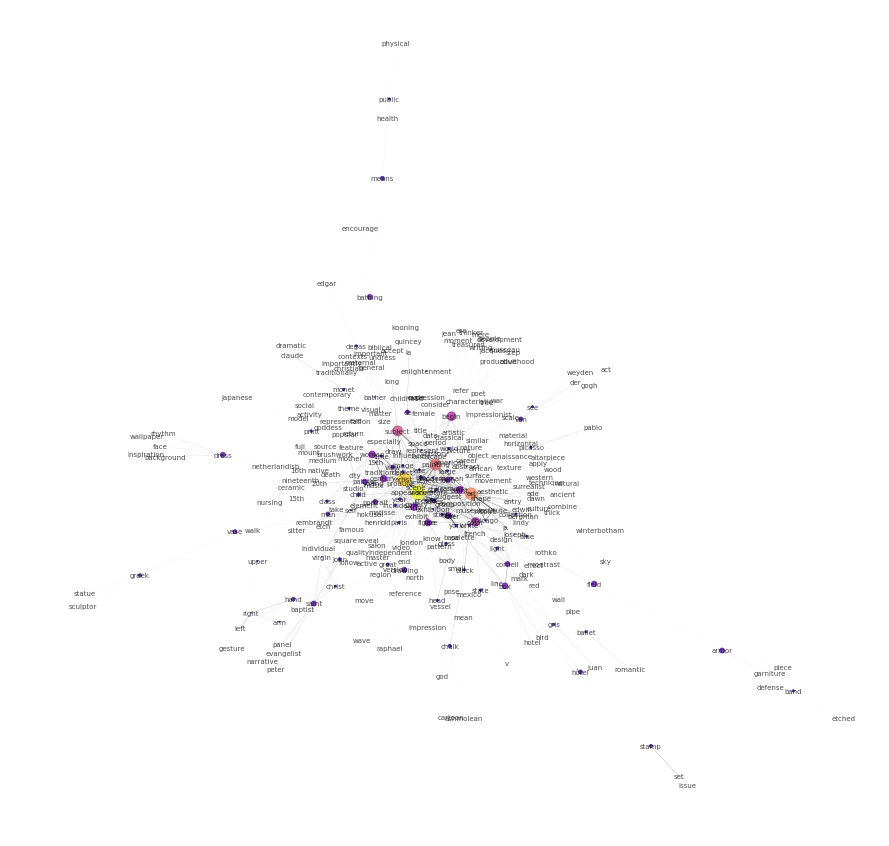

In [208]:
fig, ax = plt.subplots(figsize = (15,15))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .7, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'), 
       font_size=7) 

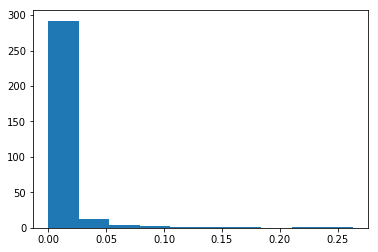

In [209]:
# The distrubution of betweenness centrality
plt.hist(list(centralities.values()))
plt.show()

In [210]:
# the top ten words in terms of betweenness
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.2984126984126984),
 ('artist', 0.24761904761904763),
 ('painting', 0.21587301587301588),
 ('art', 0.19682539682539682),
 ('subject', 0.1619047619047619),
 ('paint', 0.12063492063492064),
 ('begin', 0.09841269841269841),
 ('color', 0.09841269841269841),
 ('century', 0.09523809523809523),
 ('form', 0.09523809523809523)]

The two main subjects that museum language talks about are work and artis. The Art Institute of Chicago is an Art museum, and we can see that 'painting' ranks the first among other words besdies 'work' and 'artist' in terms of betweenness.

In [211]:
# the bottom ten words in terms of betweenness
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('armor', 0.022222222222222223),
 ('glass', 0.022222222222222223),
 ('light', 0.022222222222222223),
 ('large', 0.022222222222222223),
 ('young', 0.022222222222222223),
 ('drawing', 0.022222222222222223),
 ('black', 0.022222222222222223),
 ('self', 0.022222222222222223),
 ('theme', 0.01904761904761905),
 ('chalk', 0.01904761904761905)]

In [215]:
# closeness centrality

In [213]:
centralities = nx.closeness_centrality(giant)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


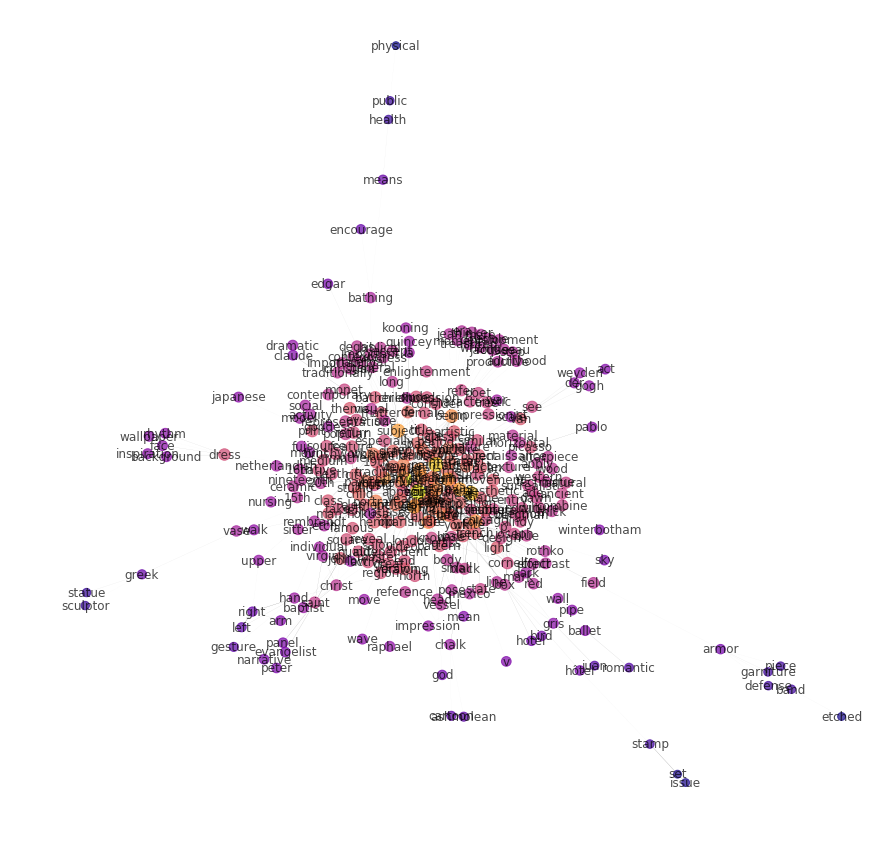

In [216]:
fig, ax = plt.subplots(figsize = (15,15))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .7, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'), 
       font_size =12) 

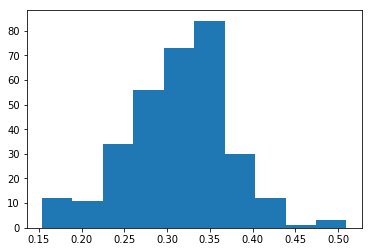

In [219]:
# The distrubution of closeness centrality
plt.hist(list(centralities.values()))
plt.show()

In [217]:
# the top ten words in terms of closeness
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.5097087378640777),
 ('artist', 0.5031948881789138),
 ('painting', 0.4743975903614458),
 ('art', 0.4639175257731959),
 ('early', 0.4350828729281768),
 ('paint', 0.43388429752066116),
 ('subject', 0.4315068493150685),
 ('form', 0.42625169147496617),
 ('life', 0.42168674698795183),
 ('century', 0.42112299465240643)]

In [218]:
#  the bottom ten words in terms of closeness
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('piece', 0.18772348033373062),
 ('garniture', 0.18772348033373062),
 ('public', 0.18166089965397925),
 ('health', 0.18155619596541786),
 ('sculptor', 0.18),
 ('statue', 0.18),
 ('issue', 0.15949367088607594),
 ('set', 0.15949367088607594),
 ('etched', 0.15829145728643215),
 ('physical', 0.15380859375)]

In [220]:
# einvector centrality

In [221]:
centralities = nx.eigenvector_centrality(giant)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


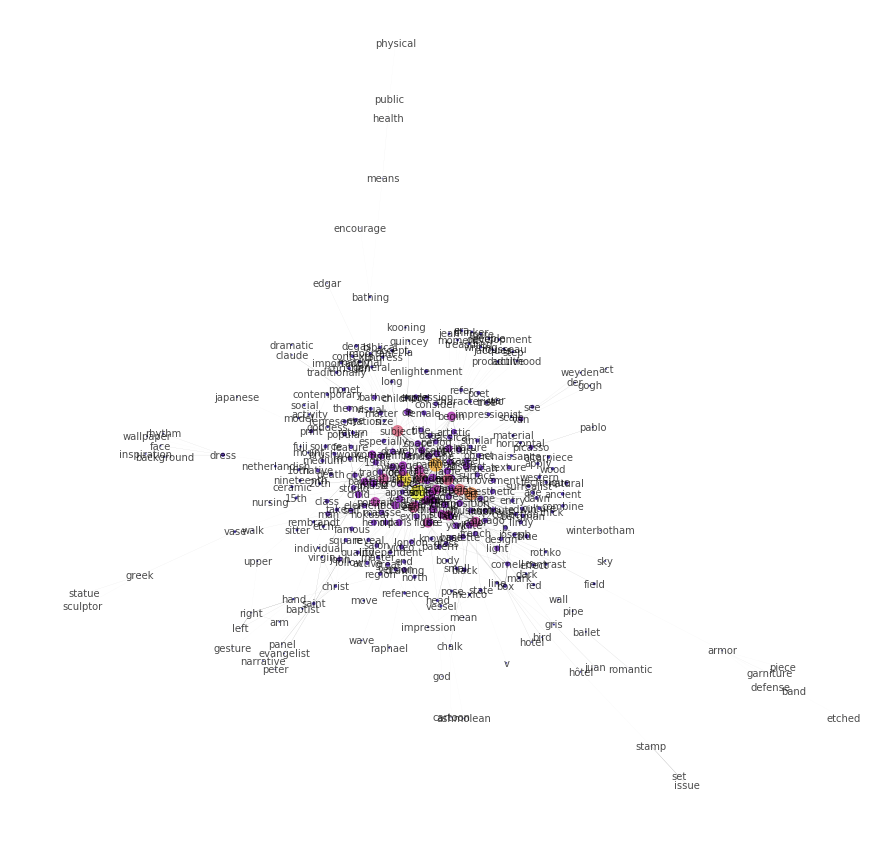

In [224]:
fig, ax = plt.subplots(figsize = (15,15))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .7, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'), 
       font_size=10) 

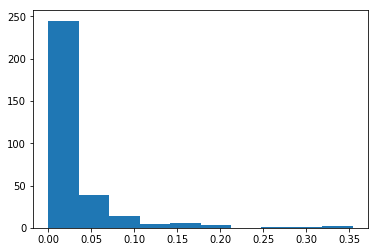

In [225]:
# The distrubution of einvector centrality
plt.hist(list(centralities.values()))
plt.show()

In [227]:
# the top ten words in terms of einvector centrality
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.354105865748716),
 ('artist', 0.3304207871118119),
 ('painting', 0.2923104800687482),
 ('art', 0.2541388894497503),
 ('paint', 0.20370836527078187),
 ('subject', 0.19125771511197664),
 ('form', 0.18324826757125032),
 ('early', 0.1687564977805814),
 ('life', 0.16444466300265936),
 ('century', 0.15795136240726565)]

In [226]:
# the bottom ten words in terms of einvector centrality
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('piece', 2.1507931033058025e-05),
 ('garniture', 2.1507931033058025e-05),
 ('sculptor', 1.3333511688766586e-05),
 ('statue', 1.3333511688766586e-05),
 ('public', 1.2697151364090018e-05),
 ('health', 1.2665235619754444e-05),
 ('set', 2.592567987429299e-06),
 ('issue', 2.4657341394612944e-06),
 ('etched', 1.1084527380948594e-06),
 ('physical', 6.526879571253754e-07)]

The results of the most central words are robust among differnet measures: 
'work',
'artist',
'painting',
'art',
'paint',
'subject',
'form',
'early',
'life',
'century'

But the least central words are somewhat not certain. This is due to the different standards of the methods of measurement. For the most central words, since this corpus shows a strong pattern of concentrating on 'artist', 'work', etc, the results are robust. But for the least central words, the results can significant vary when the method changes. For this specific museum language corpus, the most central words turn out to be those that describe the objective, or the central topics, of the description texts. 

In [233]:
# global statistics

In [234]:
nx.density(giant)

0.016395418927064496

In [235]:
np.mean([v for w,v in nx.degree(giant)])

5.1645569620253164

In [236]:
nx.diameter(giant)

10

The mean and diameter of the network are relatively large, and the density is relatively small. This may reveal an important pattern of the museum language: the vocabulary is very rich and diffusive. Except for the most central words that describe the central topic of museum languages, other words that are used for documenting or introducing the artworks or artists are tramendously rich. 

# POS based networks

Now let's look at links between specific parts of speech within a network.



Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [86]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [87]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

author  over_18  score                subreddit  \
99  jimmy_three_shoes    False   4990  Tales From Tech Support   
98         badbfriend    False   5034            Relationships   
97             Fafrdr    False   5146            Relationships   

                                                 text  \
99  This happened a little while ago, when I was c...   
98  https://www.reddit.com/r/relationships/comment...   
97  First post: https://www.reddit.com/r/relations...   

                                                title  \
99   We've tried nothing, and we're all out of ideas!   
98  Me [29 M] with my g/f [27 F] together 4 years,...   
97  Update - My [16F] father [59M] acts creepy tow...   

                                                  url  \
99  https://www.reddit.com/r/talesfromtechsupport/...   
98  https://www.reddit.com/r/relationships/comment...   
97  https://www.reddit.com/r/relationships/comment...   

                                            sentences  
99  [[This, happened, a, little, while, ago, when,...  
98  [[https://www.reddit.com/r/relationships/comme...  
97  [[First, post, https://www.reddit.com/r/relati...

Now we'll normalize the tokens through stemming:

In [88]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

We will revisit spacy and use it's english language model.

In [89]:
import spacy

In [90]:
nlp = spacy.load('en')

In [91]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [92]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [93]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2012
Number of edges: 11934
Average degree:  11.8628


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [94]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 221
Average degree:  18.4167


And low weight edges:

In [95]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 80
Average degree:   6.6667


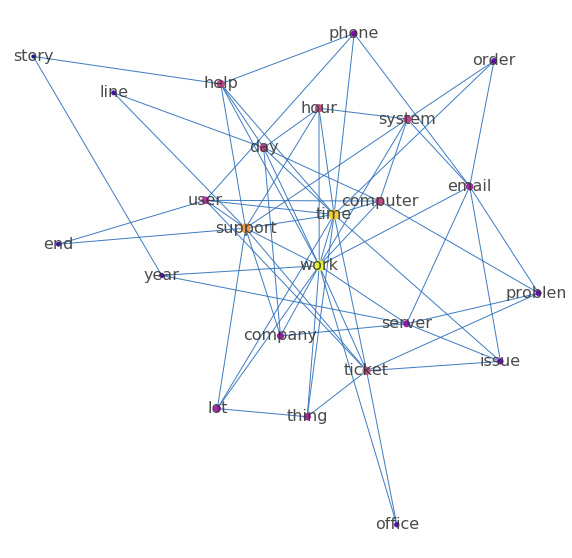

In [96]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

That is an interesting pattern; everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [97]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [98]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2161
Number of edges: 18115
Average degree:  16.7654


In [99]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [100]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2161
Number of edges: 5786
Average degree:   5.3549


Dropping low weight edges and low degree vertices gives us:

In [101]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [102]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 20
Number of edges: 50
Average degree:   5.0000


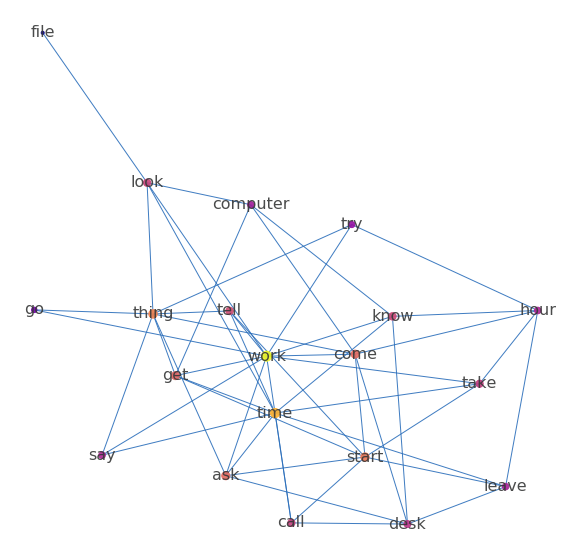

In [103]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [104]:
g_i = gNV.subgraph(['work'] + list(gNV.neighbors('work')))

In [105]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 11
Average degree:   1.8333


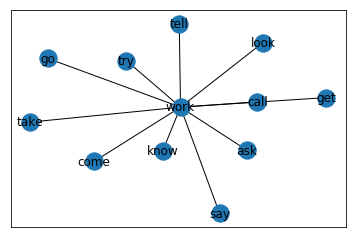

In [106]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'look' (+ points for being meta) for this:

In [107]:
storyNeighbors = gNV.neighbors('look')
set(storyNeighbors)

{'computer', 'file', 'thing', 'time', 'work'}

In [108]:
storyNeighbors = set(gNV.neighbors('look'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [109]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 17
Number of edges: 33
Average degree:   3.8824


This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [110]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.6875),
 ('time', 0.5625),
 ('thing', 0.5),
 ('look', 0.3125),
 ('computer', 0.25),
 ('get', 0.25),
 ('know', 0.1875),
 ('tell', 0.1875),
 ('say', 0.1875),
 ('come', 0.1875)]

Or eigenvector centrality:

In [111]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.45363345471384553),
 ('time', 0.3657602779138192),
 ('thing', 0.3494247945382785),
 ('look', 0.28025415645119023),
 ('get', 0.26921641691621967),
 ('tell', 0.23195961462158712),
 ('say', 0.23195961462158712),
 ('ask', 0.23195961462158712),
 ('know', 0.19987080098426385),
 ('come', 0.1966289183966515)]

Lets plot it:

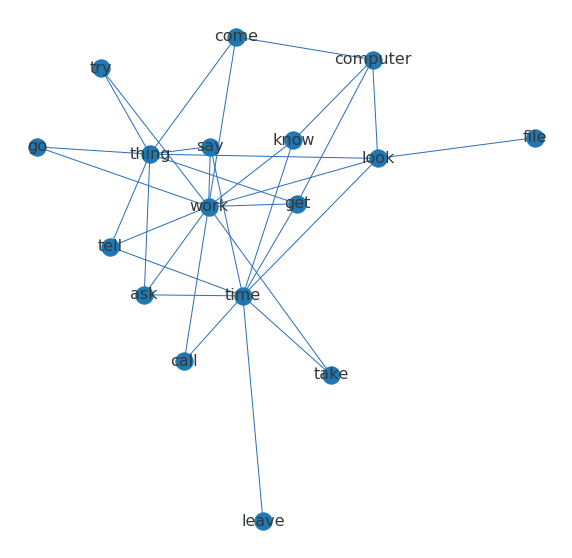

In [112]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

Lets create a noun-adjective network:

In [113]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 2683
Number of edges: 20010
Average degree:  14.9161


By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [114]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 77
Average degree:   6.1600


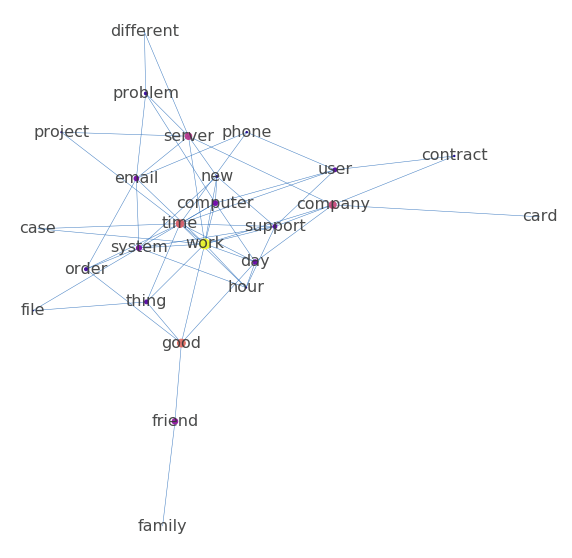

In [115]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [241]:
# import spacy for POS classification
import spacy
nlp = spacy.load('en')

In [242]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [293]:
# noun-verb network
gNV = posCooccurrence(art_chicago['normalized_sents'].sum(), 'NN', 'VB')

In [294]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2978
Number of edges: 30158
Average degree:  20.2539


In [295]:
# gNV has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [296]:
# Dropping low weight edges and low degree vertices
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 2])

In [299]:
# there remains one outlier, drop again. 
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 1])

In [297]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 22
Number of edges: 35
Average degree:   3.1818


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


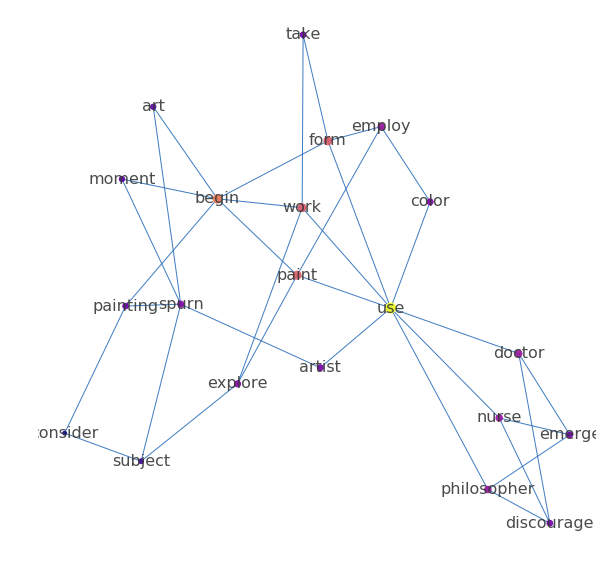

In [300]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

In [361]:
# noun-adjective network
gNJ = posCooccurrence(art_chicago['normalized_sents'].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 4033
Number of edges: 53434
Average degree:  26.4984


In [362]:
gNJ.remove_edges_from([(n1,n2) for n1,n2,d in gNJ.edges(data = True) if gNJ.nodes[n1]['bipartite'] == gNJ.nodes[n2]['bipartite']])

# Dropping low weight edges and low degree vertices
gNJ.remove_edges_from([(n1, n2) for n1, n2, d in gNJ.edges(data = True) if d['weight'] <= 3])
gNJ.remove_nodes_from([n for n in gNJ.nodes if len(set(gNJ.neighbors(n))) <= 3])

In [363]:
gNJ = max(connected_component_subgraphs(gNJ), key=len)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


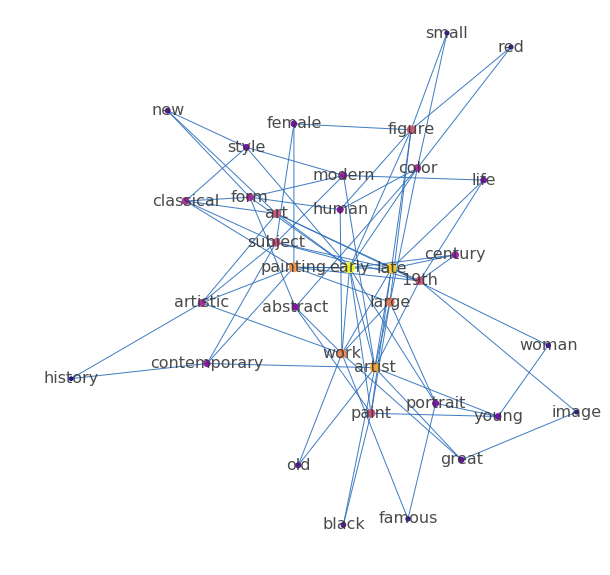

In [364]:
layout_nj = nx.spring_layout(gNJ, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj = nx.eigenvector_centrality(gNJ)
maxC = max(centralities_nj.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNJ.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNJ.edges(data = True)))
nx.draw(gNJ, ax = ax, pos = layout_nj, labels = {n: n for n in gNJ.nodes()},
#         width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNJ.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nj[n] / maxC for n in gNJ.nodes],
        node_size = [centralities_nj[n] / maxC * 100 for n in gNJ.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

In [372]:
# ego network surrounding a word
g_i = gNJ.subgraph(['painting'] + list(gNJ.neighbors('painting')))

In [373]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 9
Number of edges: 8
Average degree:   1.7778


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


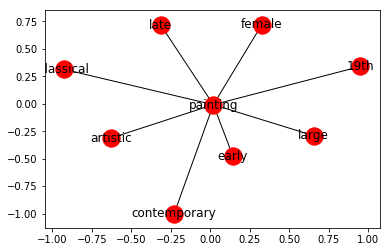

In [374]:
nx.draw_networkx(g_i)

In [375]:
# Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at a word (+ points for being meta) for this:
storyNeighbors = gNV.neighbors('painting')
set(storyNeighbors)

{'begin', 'consider', 'spurn'}

In [376]:
storyNeighbors = set(gNV.neighbors('painting'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [377]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 11
Number of edges: 13
Average degree:   2.3636


In [378]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('begin', 0.6000000000000001),
 ('spurn', 0.5),
 ('painting', 0.30000000000000004),
 ('consider', 0.2),
 ('moment', 0.2),
 ('art', 0.2),
 ('subject', 0.2),
 ('artist', 0.1),
 ('paint', 0.1),
 ('form', 0.1)]

In [379]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('begin', 0.5005982336394996),
 ('spurn', 0.4582955146171254),
 ('painting', 0.3827438215465538),
 ('moment', 0.31712531303916974),
 ('art', 0.31712531303916974),
 ('subject', 0.2171865679924697),
 ('consider', 0.19840961141183136),
 ('paint', 0.16555725355434994),
 ('form', 0.16555725355434994),
 ('work', 0.16555725355434994)]

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


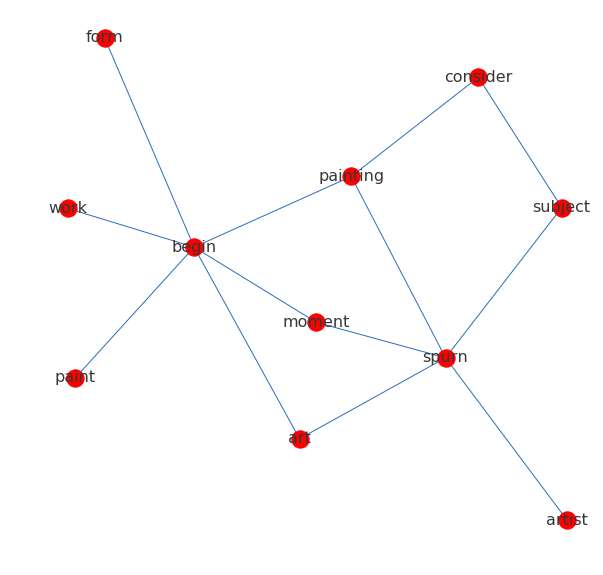

In [380]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [386]:
# Let's see what did artists spurn? 
for index, row in art_chicago.iterrows(): 
    if 'spurn' in row['description_text_merge']: 
        print(row)

artwork_title                          Woman Bathing, 1890–91, Mary Cassatt
description_text_merge    Images of women washing themselves are ubiquit...
metadata                  Artist\nMary Cassatt\nTitle\nWoman Bathing\nOr...
url                       https://www.artic.edu/artworks/13506/woman-bat...
tokenized_sents           [[Images, of, women, washing, themselves, are,...
normalized_sents          [[image, woman, wash, ubiquitous, history, wes...
Name: 746.0, dtype: object
artwork_title                           Elaine, 1874, Toby Edward Rosenthal
description_text_merge    Toby Edward Rosenthal found inspiration for th...
metadata                  Artist\nToby Edward Rosenthal\nTitle\nElaine\n...
url                             https://www.artic.edu/artworks/72320/elaine
tokenized_sents           [[Toby, Edward, Rosenthal, found, inspiration,...
normalized_sents          [[toby, edward, rosenthal, find, inspiration, ...
Name: 990.0, dtype: object
artwork_title             Woman at

'Spurn' appears three times, all of which are in the same repeated sentence "However, in the late 19th century progressive artists spurned traditional history painting in favor of contemporary subject matter—art of the moment that represented real life. The artists featured in this gallery made the theme of the bathing woman thoroughly modern. "

## Creating networks of agents from corpora

Now that we have an idea of how we can use networks in python (a useful skill to know!), let us see how we can now use our knowledge of networks on extracting actors from corpora and building relations from them. Let us use the soap opera corpus now. 

In the last notebook we wrote methods to load corpora - this has been added to lucem_illud_2020.
The code returns a dictionary with each id mapping to the text associated with it. 

We would then use the source file to create the dataframe with the data - since this varies for each corpora, there is no built in function, but would follow a similar process.

This function might take some time.

In [116]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [117]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


We now use the source to see how the data is stored. Note that this is different from the movies corpus, and that we will need to use a different aggregating method to store the data. Each dataset would have a different approach, but they are all very similar, it depends on how the data is stored. Here multiple textids match multiple scripts, so our soap dataframe would be structured a little differently. 

You can see the first 20 lines of the source file here.

In [118]:
import zipfile

In [119]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [120]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [121]:
source[0:20]

[b'textID\tyear\tshow\t\turl\r\n',
 b'-----\t-----\t-----\t\t-----\r\n',
 b'\r\n',
 b'1\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-04-09-01.shtml\r\n',
 b'2\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-05-09-01.shtml\r\n',
 b'3\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-06-20-01.shtml\r\n',
 b'4\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-07-01.shtml\r\n',
 b'5\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-08-01.shtml\r\n',
 b'6\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-09-01.shtml\r\n',
 b'7\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-10-01.shtml\r\n',
 b'8\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-13-01.shtml\r\n',
 b'9\t2001\tAll My Childen\thttp://tvmegasite.net/tra

In [122]:
import pandas as pd

In [123]:
soap_dict = {}

In [124]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [125]:
soap_dict.keys()

dict_keys(['Port Charles', 'All My Childen', 'General Hospital', 'Bold and Beautiful', 'Guiding Light', 'Young and Restless', 'Passions', 'One Life to Live', 'Days of Our Lives', 'As the World Turns'])

In [126]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [127]:
i = 0

In [128]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

Port Charles
All My Childen
General Hospital
Bold and Beautiful
Guiding Light
Young and Restless
Passions
One Life to Live
Days of Our Lives
As the World Turns


In [129]:
soap_df

Soap Name                                    Tokenized Texts
0        Port Charles  [@!Gabriela, Normal, How, 'd, you, sleep, @!Ev...
1      All My Childen  [@!Edmund, No, doubt, about, it, ER, nurse, ha...
2    General Hospital  [@!Stavros, Perhaps, this, will, help, you, fe...
3  Bold and Beautiful  [@!Amber, Oh, look, at, that, It, 's, a, wonde...
4       Guiding Light  [@!Edmund, And, that, was, the, day, I, knew, ...
5  Young and Restless  [@!Victor, John, call, the, D.A, Tell, him, my...
6            Passions  [@!Tabitha, I, can, feel, it, Timmy, We, 're, ...
7    One Life to Live  [@!Jen, She, paid, Chad, to, set, up, that, ho...
8   Days of Our Lives  [@!Mimi, Cute, until, someone, like, Belle, or...
9  As the World Turns  [@!Lily, What, @!Signora, Cordina, To, Malta, ...

We now have each Soap, and each of the Tokenized texts. Let us see what kind of information we can get. These are American soap operas, and are likely to be cheesy and dramatic (an understatment). A fun start would be to make networks of each of the actors and actresses in these soaps. 

What would be a good way to create a network? Maybe everytime someone talks to someone we add one weight? But we wouldn't want to add weights whenever it's a different scene - or maybe we do? Let us look at the text and figure it out.

Note that we didn't add the year here because it spans over multiple years. If we are doing different kinds of analysis we would want to a years column as well.

In my dataframe, Days of Our Lives is the 9th corpora, and I conducted my basic analysis on that.

In [244]:
dool = soap_df['Tokenized Texts'][8]

In [245]:
' '.join(dool[0:1500])

"@!Mimi Cute until someone like Belle or Shawn finds out we 're behind this @!Jan Here we go again @!Mimi This could all blow up in our faces Jan @!Jason What the hell are you guys looking at @!Belle Do you like Macy Gray Her lyrics they really speak to me She 's sensitive yet cool at the same time @!Chloe Yeah she 's all right but I 've kind of gotten into Eminem lately @!Belle You 're kidding right He 's so out there Chloe he hates women @!Chloe Oh well everyone hates something At least he does it with poetry and besides he gets his issues heard @!Belle But his issues are very scary He views life as dark and depressing @!Chloe Well then I guess you could say I have a dark view of things too just because I do n't think every day is sunshine @(Cellular phone rings @(Ring @!Chloe Hello @!Philip Hey Chloe what are you doing @!Chloe It 's Philip @!Belle He sure keeps tabs on you does n't he @!Chloe Uh it 's really funny that you called Actually I 'm in line at Salem Stadium trying to get 

Hmmm... we can't do our normal text processing. But this provides us with an interesting oppurtunity: every '@!' is followed by some useeful information. Let us do a quick check of how many characters exist here, and how many times they speak.

In [246]:
characters = {}

In [247]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [248]:
len(characters)

908

Wow, that's a lot of characters: but we notice a '@!' between certain actions too, such as screaming and sobbing. Let us maybe only look for characters with a high number of appearances?

In [249]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Shawn 2708
Brady 2410
Belle 2739
Kate 2770
Sami 4998
John 2404
Lucas 2518
Nicole 3170
Hope 3189
Bo 3753
Philip 2710
Marlena 2298


Let's check these folks out on the interwebz...a image of search of the name + "days of our lives":

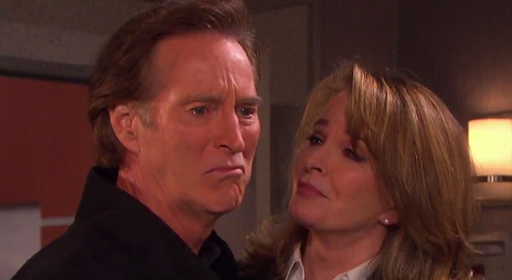

In [135]:
Image(filename='../data/dool/dool_john.png') 

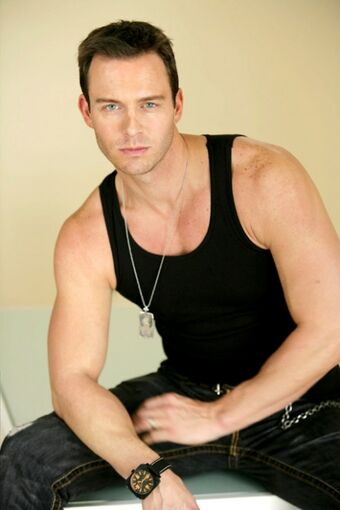

In [136]:
Image(filename='../data/dool/dool_brady.jpg') 

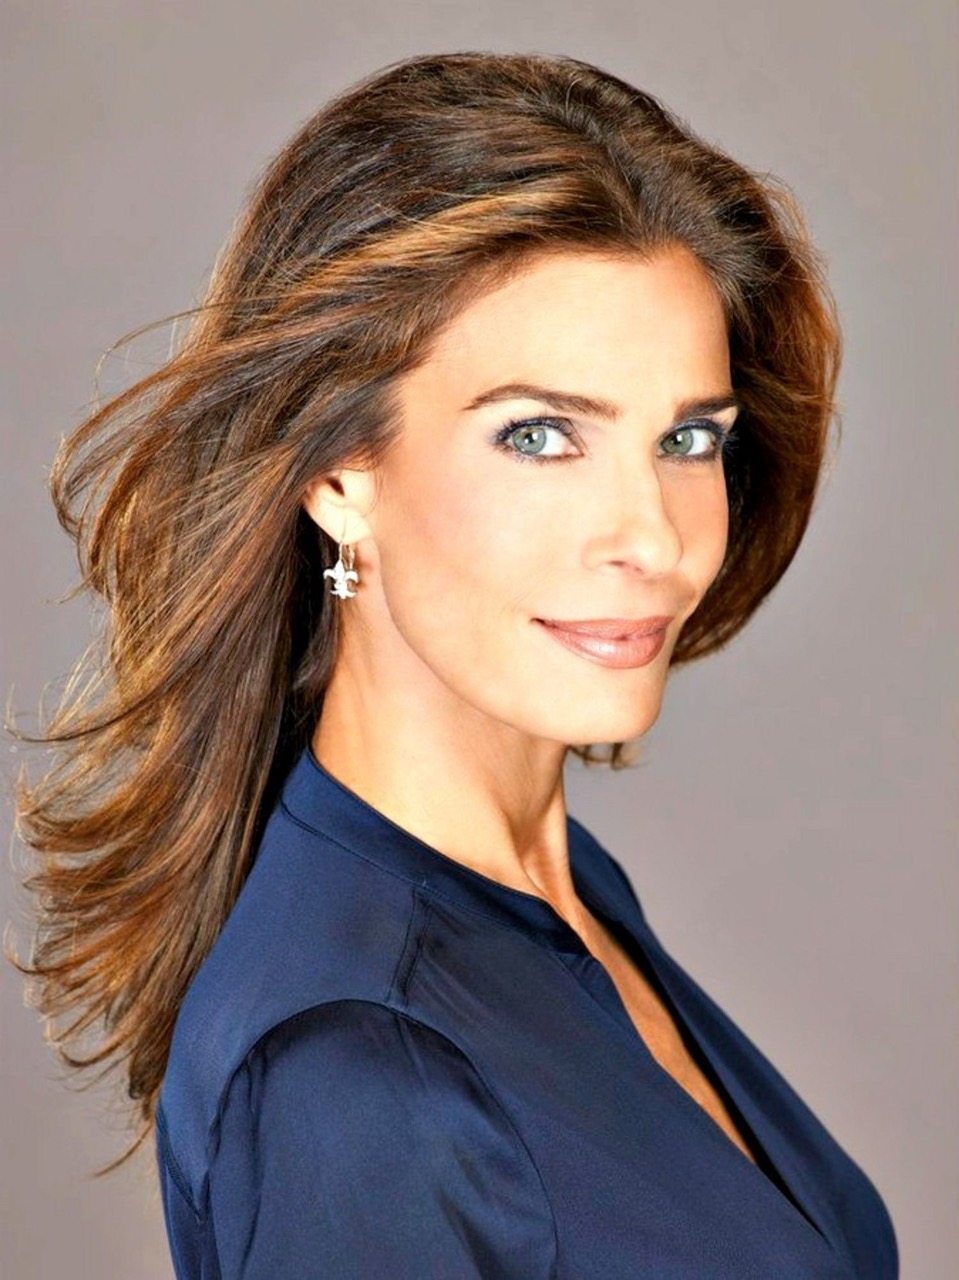

In [139]:
Image(filename='../data/dool/dool_hope.jpeg')

In [141]:
# Image(filename='../data/dool/dool_philip.jpeg')

In [224]:
# Image(filename='../data/dool/dool_marlena.jpg')

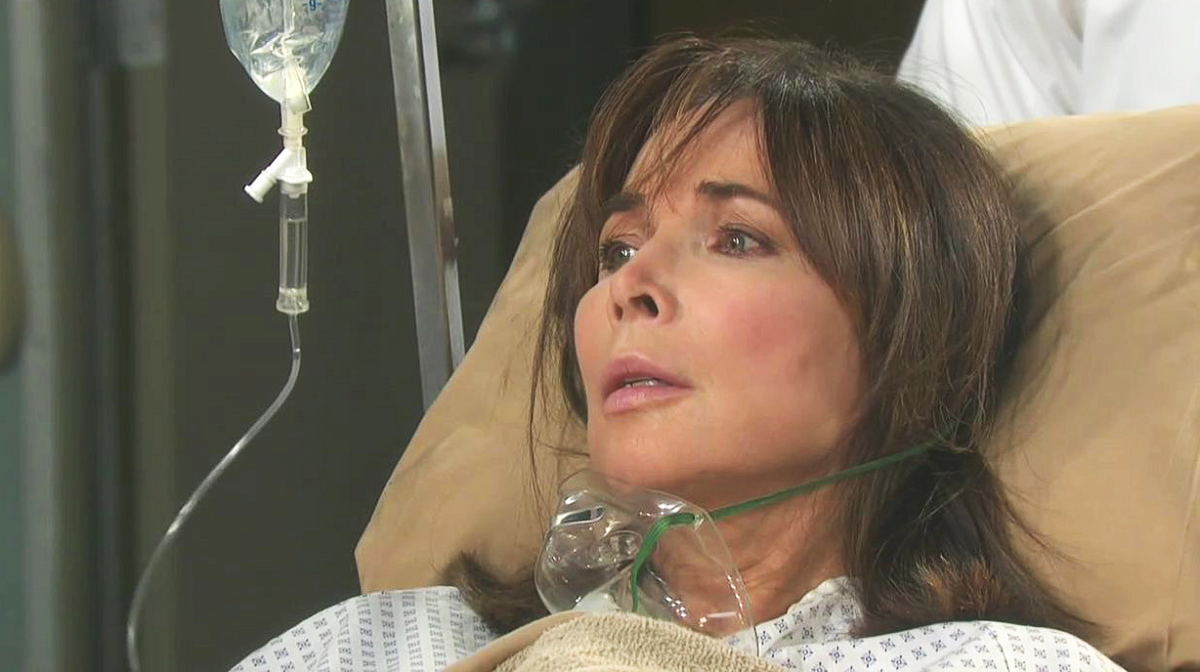

In [143]:
Image(filename='../data/dool/dool_kate.png')

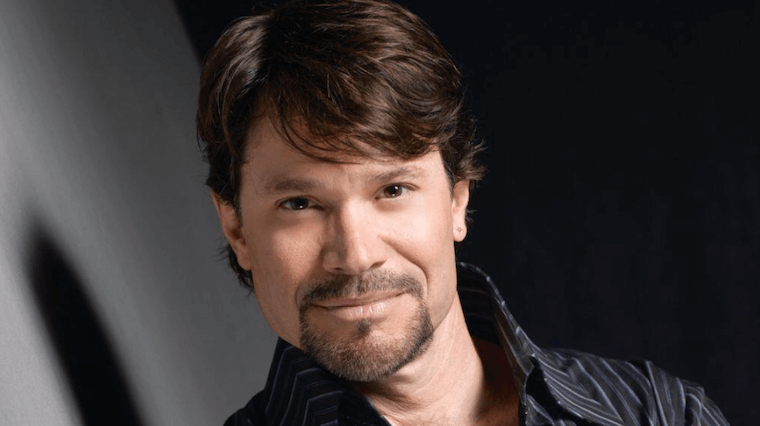

In [144]:
Image(filename='../data/dool/dool_bo.png')

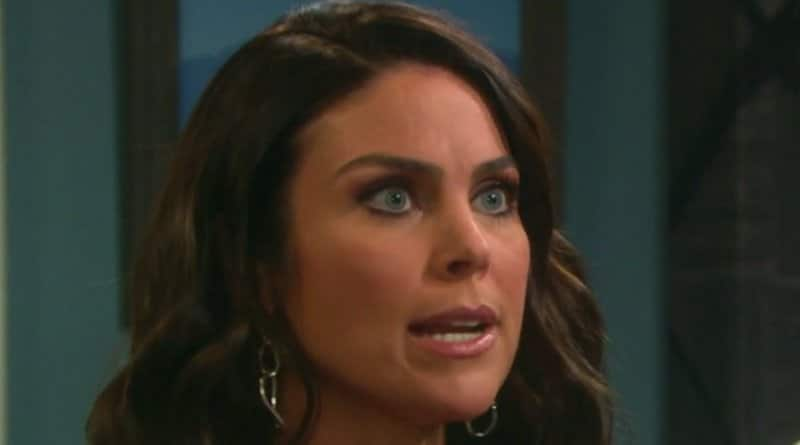

In [145]:
Image(filename='../data/dool/dool_chloe.jpg')

In [148]:
# Image(filename='../data/dool/dool_sami.jpg')

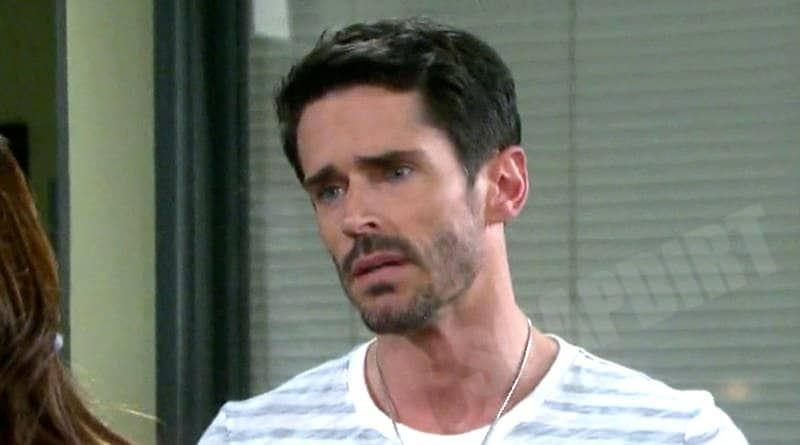

In [149]:
Image(filename='../data/dool/dool_shawn.jpg')

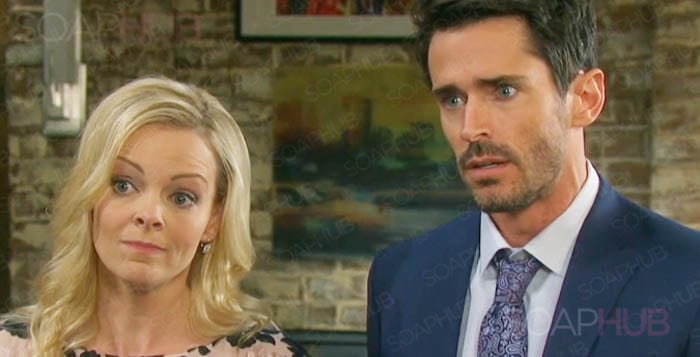

In [150]:
Image(filename='../data/dool/dool_belle.jpg')

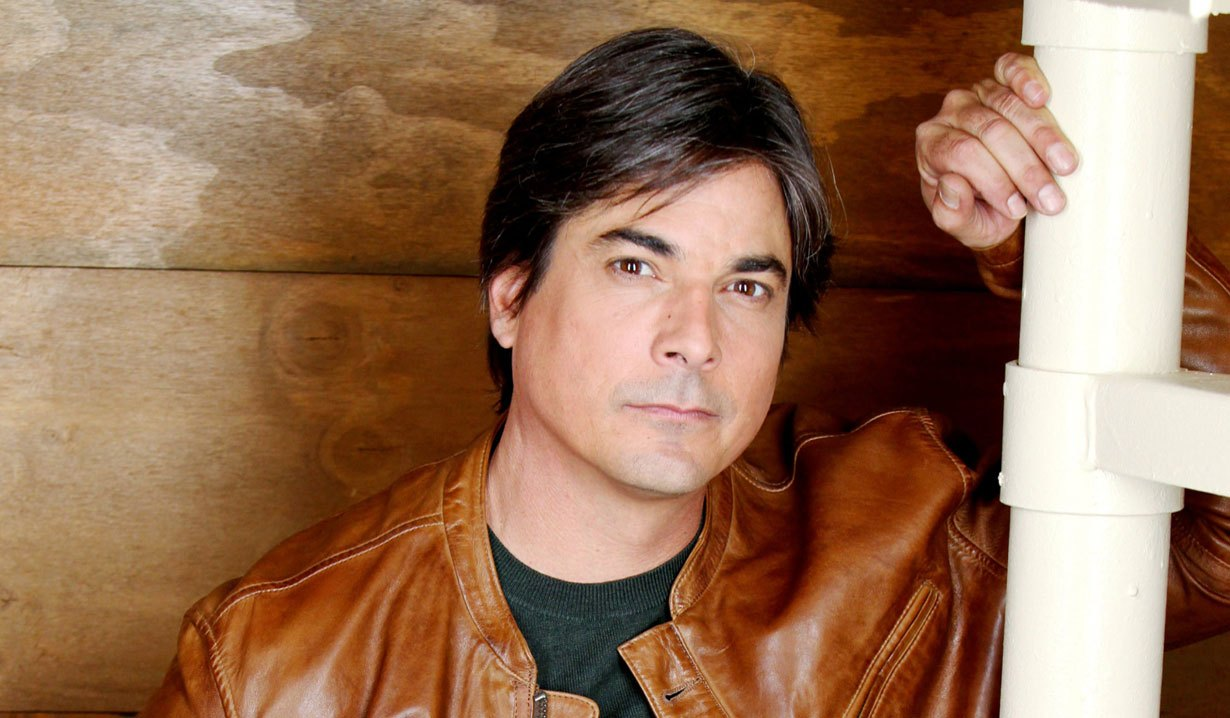

In [151]:
Image(filename='../data/dool/dool_lucas.jpg')

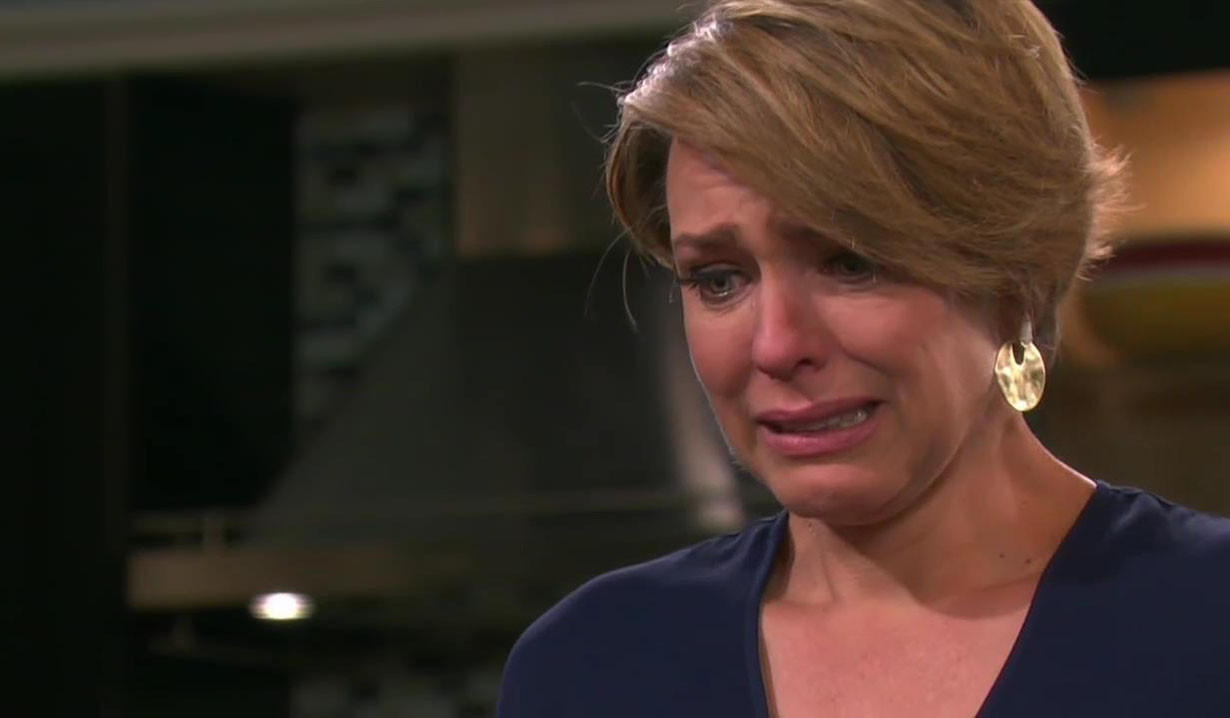

In [152]:
Image(filename='../data/dool/dool_nicole.jpg')

These are definitely big, long-time players in the dramatic Days narrative. It would make sense to create a graph where each character who appears over 2000 times is a node, and each time they talk to each other, we add one to their weight. We should also store all the things these chracters say: that's useful information.

So we now iterate through the tokens in a manner where we can capture this information.

In [250]:
actor_network = nx.Graph()

In [251]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [252]:
len(actor_network.nodes.data())

12

In [253]:
actor_network.nodes.data()

NodeDataView({'Sami': {'lines_spoken': 4998, 'words': []}, 'Lucas': {'lines_spoken': 2518, 'words': []}, 'Hope': {'lines_spoken': 3189, 'words': []}, 'Kate': {'lines_spoken': 2770, 'words': []}, 'Bo': {'lines_spoken': 3753, 'words': []}, 'Shawn': {'lines_spoken': 2708, 'words': []}, 'Brady': {'lines_spoken': 2410, 'words': []}, 'Nicole': {'lines_spoken': 3170, 'words': []}, 'John': {'lines_spoken': 2404, 'words': []}, 'Philip': {'lines_spoken': 2710, 'words': []}, 'Belle': {'lines_spoken': 2739, 'words': []}, 'Marlena': {'lines_spoken': 2298, 'words': []}})

In [254]:
actor_network.nodes['Sami']['lines_spoken']

4998

In [255]:
i = 0

The following lines of code creates the graph. Please carefully go through the code: you should be able to understand (more or less) what is going on here. 

In [256]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

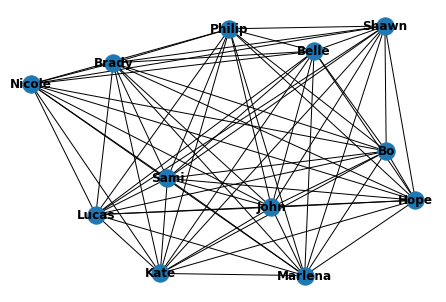

In [257]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [258]:
import seaborn as sns

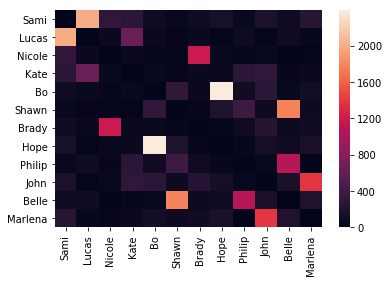

In [259]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [260]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [261]:
c

[frozenset({'Belle',
            'Bo',
            'Brady',
            'Hope',
            'John',
            'Kate',
            'Lucas',
            'Marlena',
            'Nicole',
            'Philip',
            'Sami',
            'Shawn'})]

We now have a lot of useful information: we have a graph of all the characters, with their relationships with other characters, as well as all the words they've said. We tried finding communities, but it seems like everyone is connected to everyone: each of them form their own community. Seems like people talk to each other a bunch in soaps.

This means we can explore ideas contained in two of the papers you will be reading: . “No country for old members: User lifecycle and linguistic change in online communities.”, and  “Fitting In or Standing Out? The Tradeoffs of Structural and Cultural Embeddedness”, both of which you can access on Canvas. 

Let us use a simplified version of the papers, and check if a higher number of conversations might lead to a higher similarity between the word distributions for two characters. We can use the same divergences we used in the last notebook. Do you think it will match with the number of times each character was associated with each other?

In [262]:
import nltk

In [263]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [264]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud_2020.normalizeTokens(character_words))

In [265]:
L = []

In [266]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

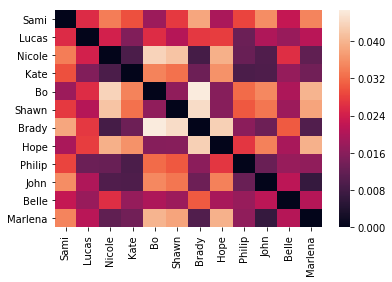

In [267]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [268]:
# np.corrcoef(M_, M)[0]

With our two heatplots, we can attempt to do some rudimentary analysis. We can see from our previous plot that Shawn and Belle talk to each other a lot, so do Hope and Bo, and Nicole and Brady, and Lucas and Sami. Do they also talk *like* each other?

Kind of, actually: all four of these pairs have a lower distance between them. Now I don't know anything about this particular soap... are these four pairs related? Are they in a relationship, either married or dating, or are they just really good friends?

This lays out the frameworks which you can now use to explore your own networks. 

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [209]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [210]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [211]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [212]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

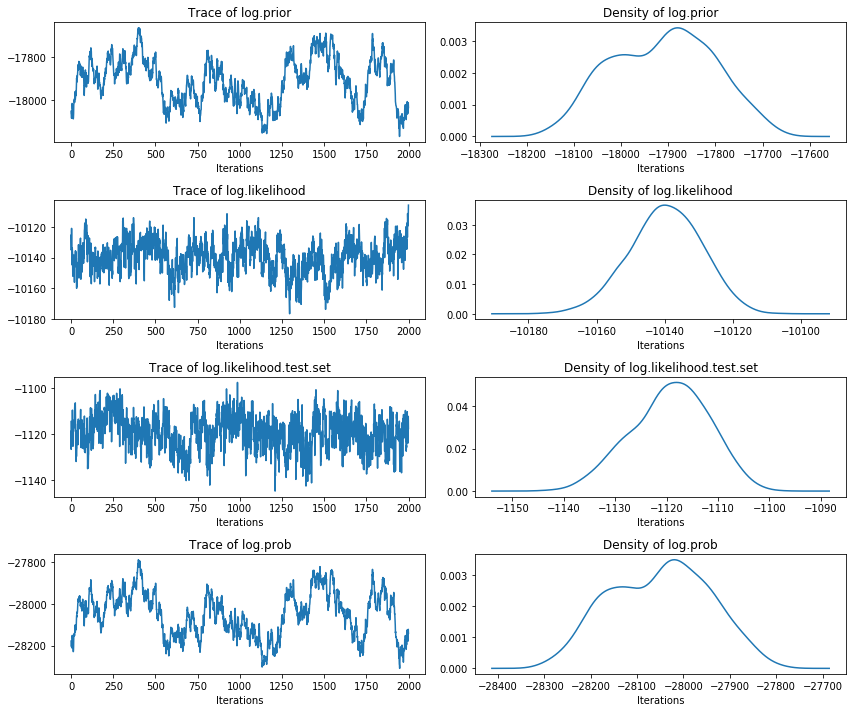

In [213]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [214]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [215]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [216]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [217]:
df_mean

Juror 8   Juror 3  Juror 10   Foreman   Juror 7   Juror 4  \
Juror 8   0.000000  3.757957  8.089079  0.930180  5.167497  0.794645   
Juror 3   8.529312  0.000000  6.673916  4.150076  2.534751  4.902852   
Juror 10  8.413188  7.427932  0.000000  4.540236  3.216307  1.030049   
Foreman   1.137060  0.612615  1.945196  0.000000  1.521390  0.834870   
Juror 7   2.603853  5.901169  0.648844  1.969868  0.000000  1.110101   
Juror 4   5.791320  0.200669  0.266484  0.582956  0.094200  0.000000   
Juror 11  0.378515  0.544628  0.779340  0.454645  0.290575  0.447512   
Juror 12  5.961338  0.695831  0.519459  1.253033  0.247939  0.162463   
Juror 6   4.526244  0.923784  0.503503  1.049825  1.288920  0.451562   
Juror 2   0.583732  2.303417  0.529583  1.722894  2.005939  0.299311   
Juror 9   1.216641  1.281288  0.967587  1.675483  1.657341  1.681338   
Juror 5   0.552951  1.001575  0.696393  1.180245  1.180355  0.497265   

          Juror 11  Juror 12   Juror 6   Juror 2   Juror 9   Juror 5  
Juror 8   0.845335  1.336329  6.106684  0.916765  6.385205  7.300776  
Juror 3   1.092571  0.509942  3.825015  3.861767  0.266426  1.561626  
Juror 10  1.004598  0.529232  2.426582  0.407460  1.233599  0.885871  
Foreman   1.338554  3.230634  1.013511  3.534036  1.311436  4.115411  
Juror 7   0.279870  0.608548  1.047693  2.910670  1.619475  1.570038  
Juror 4   3.347982  0.316963  0.300770  2.112033  0.370973  0.673364  
Juror 11  0.000000  0.614536  0.821143  0.951222  0.476986  0.844157  
Juror 12  0.388620  0.000000  2.500976  2.375977  0.481394  0.834032  
Juror 6   0.375776  0.904313  0.000000  2.861587  0.905421  0.310822  
Juror 2   0.652302  1.623813  0.841376  0.000000  1.691612  1.756225  
Juror 9   0.623032  1.925996  1.907992  0.539666  0.000000  1.138934  
Juror 5   0.786181  0.588822  0.724613  0.912616  1.224854  0.000000

MEAN of influence matrix (row=from, col=to)


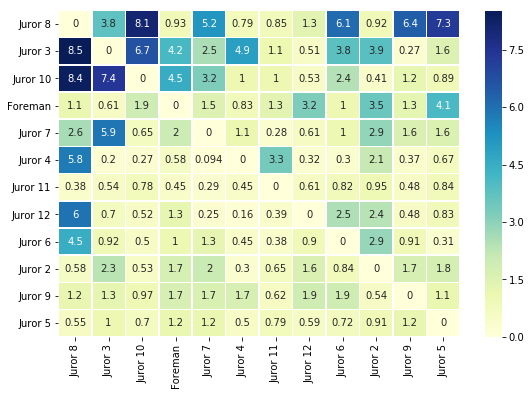

In [218]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


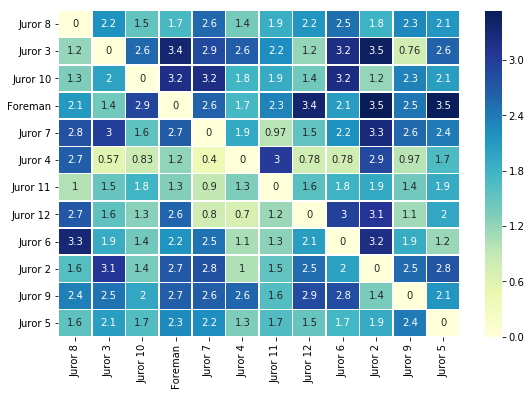

In [219]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [220]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


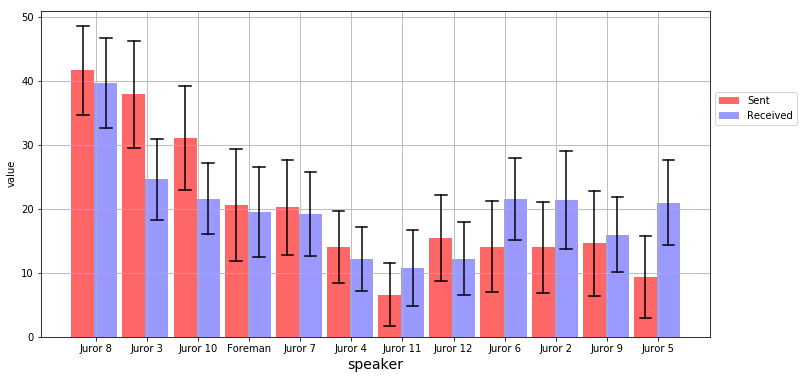

In [221]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [222]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [223]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


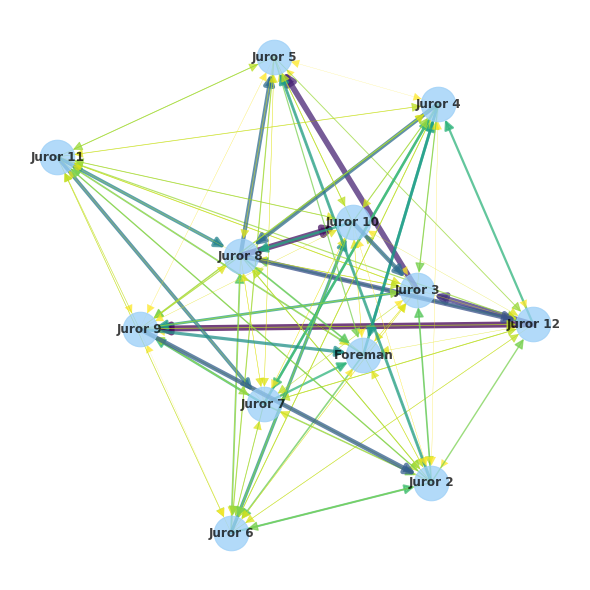

In [187]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


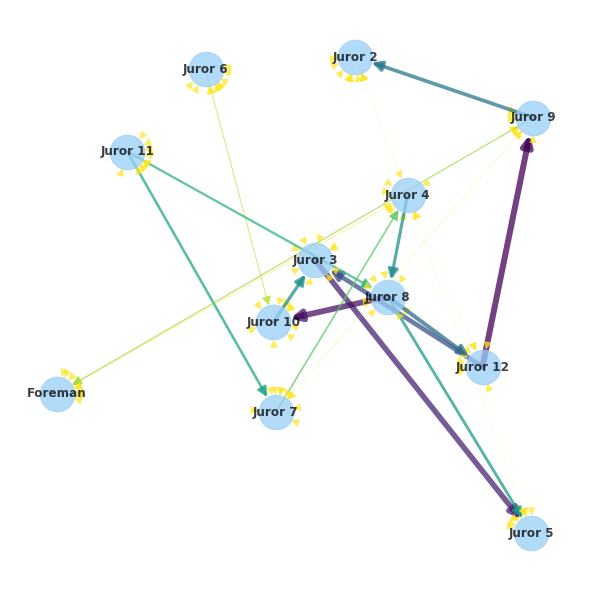

In [188]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


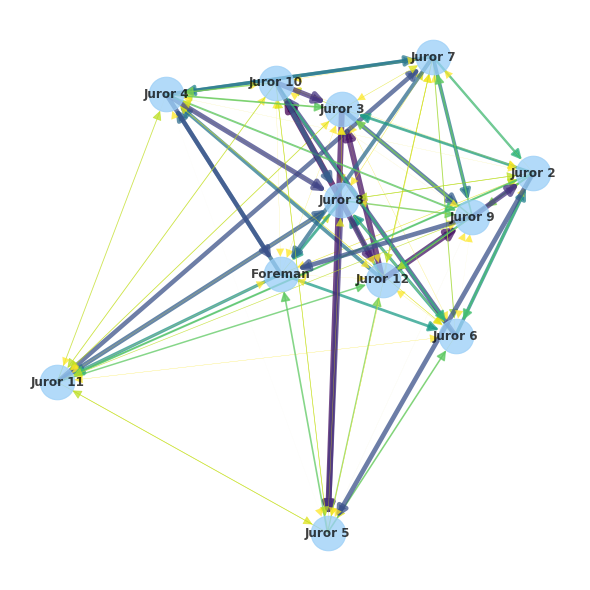

In [189]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [190]:
import lucem_illud_2020
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [191]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

name                                             tokens     start  \
0  Kennedy  [chic, lfca, echd, ekfh, gcgl, kjsb, bhgk, sjh...  0.282216   
1    Obama  [bses, bbhl, khfs, blls, lbbi, bebh, bldg, skc...  2.711259   

        end  
0  1.451031  
1  3.377750

Transform data into TalkbankXML format:

In [192]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud_2020.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [193]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud_2020.bec_run(output_fname, Vocab_size, language, sampling_time)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [436]:
# Load the corpus: this is an incomplete corpus of the text descriptions of the cellections 
# in the Art Insitute of Chicago
# The files starting with "(1," indicates the spidering was interupted by the website server
# The updated spider program is currently re-spidering the missing data to complete the corpus. 
art_chicago_info_list = []
repo = '../museum/description_metadata_in-one-file/'

for filename in os.listdir(repo): 
    if 'artwork_description_metadata' in filename and not filename.startswith('.'): 
        print(filename)
        art_chicago_info_list.append(pandas.read_csv(repo + '/' + filename, index_col=False))

art_chicago = pandas.concat(art_chicago_info_list)

0_artwork_description_metadata_1450_1500.csv
(1, 830)_artwork_description_metadata_800_850.csv
0_artwork_description_metadata_650_700.csv
0_artwork_description_metadata_700_750.csv
0_artwork_description_metadata_1650_1700.csv
(1, 1087)_artwork_description_metadata_1100_1150.csv
0_artwork_description_metadata_1300_1350.csv
0_artwork_description_metadata_750_800.csv
0_artwork_description_metadata_1400_1450.csv
0_artwork_description_metadata_1750_1800.csv
0_artwork_description_metadata_1600_1650.csv
(1, 941)_artwork_description_metadata_950_1000.csv
(1, 1087)_artwork_description_metadata_1050_1100.csv
(1, 892)_artwork_description_metadata_850_900.csv
(1, 941)_artwork_description_metadata_900_950.csv
(1, 941)_artwork_description_metadata_1000_1050.csv
0_artwork_description_metadata_1550_1600.csv
(1, 1180)_artwork_description_metadata_1150_1200.csv
0_artwork_description_metadata_1800_1850.csv
(1, 1180)_artwork_description_metadata_1200_1250.csv
0_artwork_description_metadata_1500_1550.csv
0

In [437]:
art_chicago['metadata_split'] = [meta.split('\n') for meta in art_chicago['metadata']]
art_chicago['metadata_split'].head(3)

0    [Artist, Henry Fuseli, Title, Head of a Damned...
1    [Artist, Katsushika Hokusai, Title, Under the ...
2    [Artist, Katsushika Hokusai, Title, Under the ...
Name: metadata_split, dtype: object

In [438]:
artists = []
for index, row in art_chicago.iterrows(): 
    if 'Artist' in row['metadata_split']: 
        position = row['metadata_split'].index('Artist') + 1
        artists.append(row['metadata_split'][position])
    else: 
        artists.append('')
art_chicago['artist_name'] = artists

In [439]:
art_chicago.head(5)

artwork_title  \
0  Head of a Damned Soul from Dante’s “Inferno,” ...   
1  Under the Wave off Kanagawa (Kanagawa oki nami...   
2  Under the Wave off Kanagawa (Kanagawa oki nami...   
3                  Stowing Sail, 1903, Winslow Homer   
4                  Clothespin, 1975, Claes Oldenburg   

                                    description_text   index  \
0  Born into a family of artists in Zurich, Henry...  1451.0   
1  Katsushika Hokusai’s much celebrated series, T...  1452.0   
2  The most famous image from the set is the "Gre...  1452.0   
3  Homer created sparkling watercolor sketches of...  1457.0   
4  Over the last 50 years, Claes Oldenburg has cr...  1460.0   

                                            metadata  \
0  Artist\nHenry Fuseli\nTitle\nHead of a Damned ...   
1  Artist\nKatsushika Hokusai\nTitle\nUnder the W...   
2  Artist\nKatsushika Hokusai\nTitle\nUnder the W...   
3  Artist\nWinslow Homer\nTitle\nStowing Sail\nOr...   
4  Artist\nClaes Oldenburg\nTitle\nClothespin\nOr...   

                                                 url  \
0  https://www.artic.edu/artworks/116101/head-of-...   
1  https://www.artic.edu/artworks/89503/under-the...   
2  https://www.artic.edu/artworks/89503/under-the...   
3  https://www.artic.edu/artworks/16831/stowing-sail   
4   https://www.artic.edu/artworks/109915/clothespin   

                                      metadata_split         artist_name  
0  [Artist, Henry Fuseli, Title, Head of a Damned...        Henry Fuseli  
1  [Artist, Katsushika Hokusai, Title, Under the ...  Katsushika Hokusai  
2  [Artist, Katsushika Hokusai, Title, Under the ...  Katsushika Hokusai  
3  [Artist, Winslow Homer, Title, Stowing Sail, O...       Winslow Homer  
4  [Artist, Claes Oldenburg, Title, Clothespin, O...     Claes Oldenburg

In [440]:
artists_list = set(art_chicago['artist_name'])

In [447]:
# merge multiple paragraphs by artist_name
# then we can perform artist - artist network

art_chicago_merge_by_artist_dict = dict()
for row_index, row in art_chicago.iterrows(): 
    if row['artist_name'] in art_chicago_merge_by_artist_dict:
        art_chicago_merge_by_artist_dict[row['artist_name']] += row['description_text']
    else: 
        art_chicago_merge_by_artist_dict[row['artist_name']] = row['description_text']

art_chicago_artists = pandas.DataFrame(data=art_chicago_merge_by_artist_dict, index=['description']).transpose()

In [525]:
art_chicago_artists.drop(index='', inplace=True)

In [527]:
art_chicago_artists.shape

(243, 3)

In [450]:
# Tokenize 
art_chicago_artists['tokenized_sents'] = art_chicago_artists['description'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
art_chicago_artists['normalized_sents'] = art_chicago_artists['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [528]:
art_chicago_artists_Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
art_chicago_artists_Vects_incidence = art_chicago_artists_Vectorizer.fit_transform(art_chicago_artists['description'])

In [529]:
# Turn the incidenc ematrix into a network. 
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((art_chicago_artists_Vectorizer.get_feature_names()[i] for i in range(art_chicago_artists_Vects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from([index for index in art_chicago_artists.index], bipartite = 'artist')

In [530]:
#add all the edges
g_2mode.add_edges_from((([index for index in art_chicago_artists.index][d], art_chicago_artists_Vectorizer.get_feature_names()[w], {'weight' : art_chicago_artists_Vects_incidence[d, w]}) for d, w in zip(*art_chicago_artists_Vects_incidence.nonzero())))

In [531]:
gArtist = contractNetwork(g_2mode, 'artist')

In [532]:
print(nx.info(gArtist))

Name: 
Type: Graph
Number of nodes: 243
Number of edges: 27077
Average degree: 222.8560


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


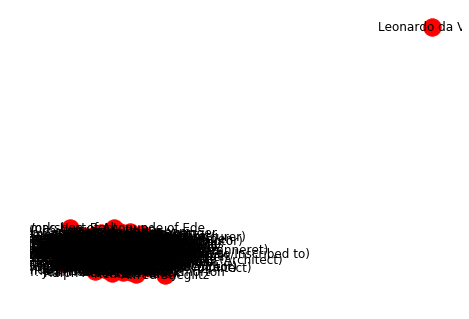

In [533]:
# construct a visualization
# how any two artists are related to each other in terms of description language
layout = nx.spring_layout(gArtist, k = 1/3, weight='weight', iterations= 50)
nx.draw(gArtist, pos = layout, labels = {n:n for n in gArtist.nodes()}) #Getting labels is a bit annoying


In [534]:
for index, row in art_chicago.iterrows(): 
    if 'Leonardo' in row['artist_name']: 
        print(row)

artwork_title       Madonna and Child (recto), and Fragment of Wom...
description_text                                McCullagh & Giles 518
index                                                            1529
metadata            Artist\nLeonardo da Vinci\nTitle\nMadonna and ...
url                 https://www.artic.edu/artworks/54937/madonna-a...
metadata_split      [Artist, Leonardo da Vinci, Title, Madonna and...
artist_name                                         Leonardo da Vinci
Name: 7, dtype: object


It's not because Leonardo da Vinci is distinct, but it is because there is no description for this work. 

Name: 
Type: Graph
Number of nodes: 121
Number of edges: 468
Average degree:   7.7355


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


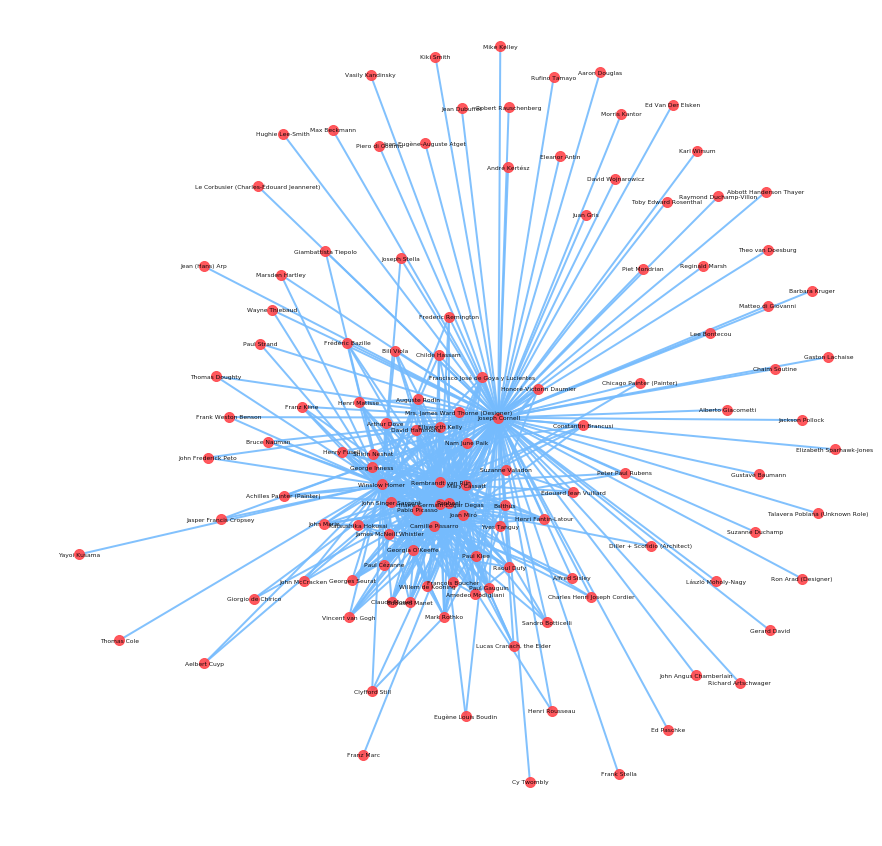

In [535]:
g = nx.Graph(gArtist)
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 20])
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] >= 160])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (15,15))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue', 
       font_size=6) #Getting labels is a bit annoying

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


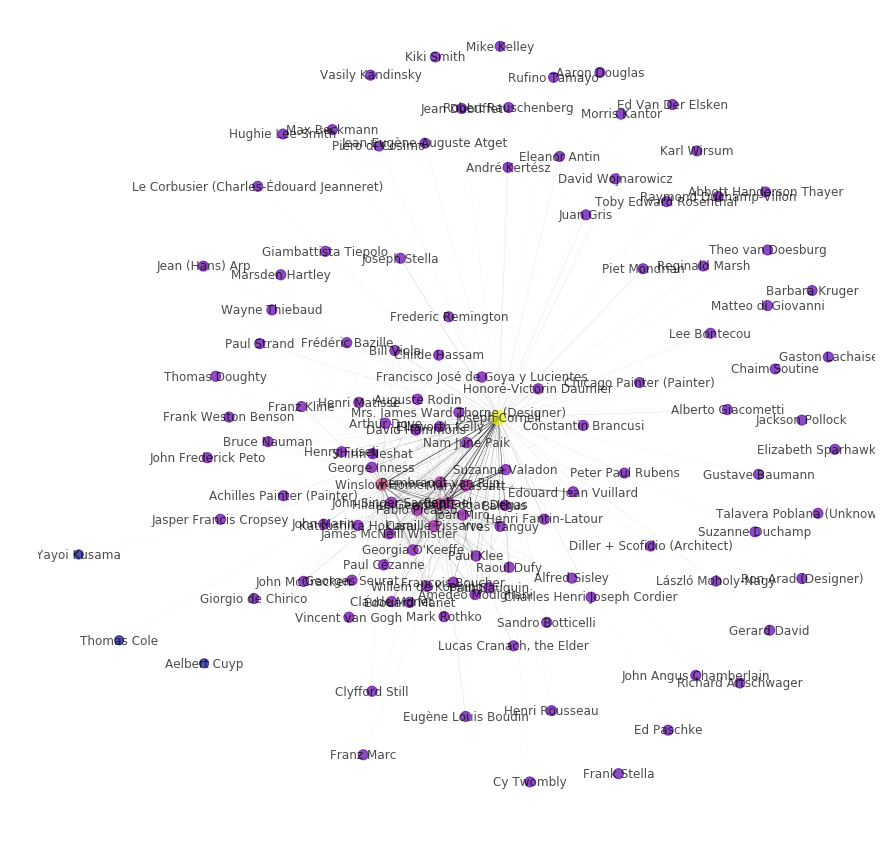

In [536]:
centralities = nx.closeness_centrality(giant)
fig, ax = plt.subplots(figsize = (15,15))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .7, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'), 
       font_size =12) 


In [537]:
# the top ten words in terms of closeness
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('Joseph Cornell', 0.975609756097561),
 ('Winslow Homer', 0.6818181818181818),
 ('Hilaire Germain Edgar Degas', 0.631578947368421),
 ('Rembrandt van Rijn', 0.6091370558375635),
 ('Mary Cassatt', 0.6060606060606061),
 ('Camille Pissarro', 0.5970149253731343),
 ('Pablo Picasso', 0.5911330049261084),
 ('Raphael', 0.5911330049261084),
 ('Joan Miró', 0.5687203791469194),
 ('John Singer Sargent', 0.5581395348837209)]

Why is Joseph Cornell so centralized?

It is very likely due to the large number of artworks collected by the musem. Try to drop it and redo the analysis. 

In [543]:
art_chicago[['artwork_title','artist_name']].groupby(['artist_name']).count().sort_values(by=['artwork_title'], ascending=False)

artwork_title
artist_name                                      
                                              111
Joseph Cornell                                 25
Rembrandt van Rijn                             10
Mary Cassatt                                    8
Winslow Homer                                   8
Hilaire Germain Edgar Degas                     8
Camille Pissarro                                7
Raphael                                         7
Georgia O'Keeffe                                5
Balthus                                         5
Katsushika Hokusai                              5
Pablo Picasso                                   5
Mrs. James Ward Thorne (Designer)               4
Shirin Neshat                                   4
Ellsworth Kelly                                 4
Paul Cézanne                                    4
John Singer Sargent                             4
Joan Miró                                       4
Giambattista Tiepolo                            3
Francisco José de Goya y Lucientes              3
Raoul Dufy                                      3
Paul Gauguin                                    3
Paul Klee                                       3
Henri Fantin-Latour                             3
James McNeill Whistler                          3
Claude Monet                                    3
Lucas Cranach, the Elder                        3
Cornelis Visscher                               3
Édouard Manet                                   3
André Kertész                                   3
...                                           ...
John Quidor                                     1
Antwerp Mannerist                               1
John Singleton Copley                           1
John Sloan                                      1
John Steuart Curry                              1
Jan van Scorel                                  1
Arnold Newman                                   1
Giorgio de Chirico                              1
Henri de Toulouse-Lautrec                       1
Giulio Campagnola                               1
Grieksche A Factory (Maker)                     1
Géraerd Ter Borch                               1
Hans Memling                                    1
Hans Sebald Beham                               1
Hans Springinklee                               1
Henri Edmond Cross                              1
Henri Joseph Harpignies                         1
Henri Rousseau                                  1
Henry Ward Ranger                               1
Jacques Geubels, I (Manufacturer)               1
Horatio Greenough (Sculptor)                    1
Hughie Lee-Smith                                1
Ilya Bolotowsky                                 1
Irving Penn                                     1
Israhel van Meckenem, the younger               1
Jackson Pollock                                 1
Jacob Cornelisz. van Oostsanen                  1
Jacob Halder                                    1
Jacob Ochtervelt                                1
Jasper Francis Cropsey                          1

[244 rows x 1 columns]

Name: 
Type: Graph
Number of nodes: 74
Number of edges: 351
Average degree:   9.4865


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


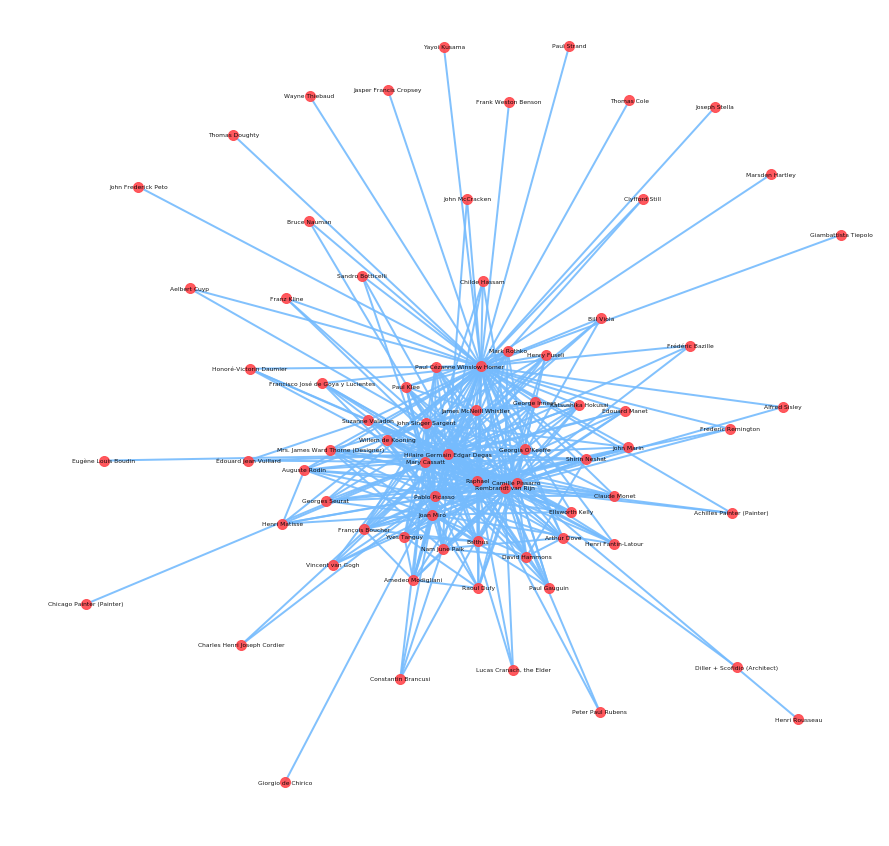

In [566]:
# Drop Joseph Cornell

g = nx.Graph(gArtist)
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 20])
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] >= 160])
g.remove_node('Joseph Cornell')
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (15,15))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue', 
       font_size=6) #Getting labels is a bit annoying

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


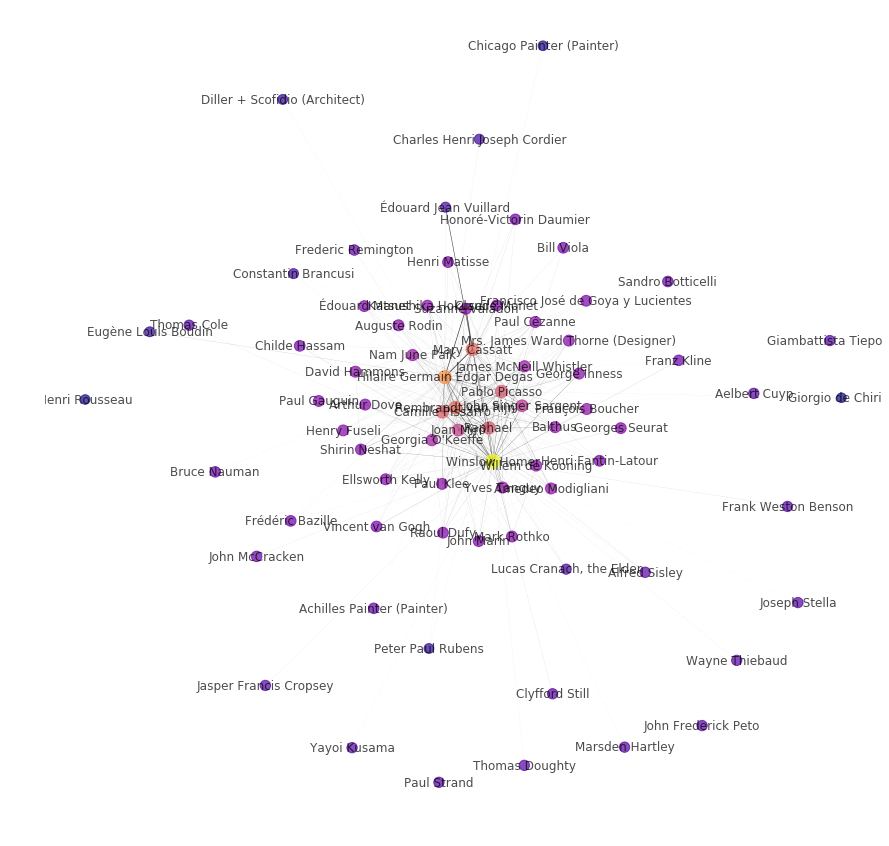

In [560]:
centralities = nx.closeness_centrality(giant)
fig, ax = plt.subplots(figsize = (15,15))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .7, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'), 
       font_size =12) 


In [561]:
# the top ten words in terms of closeness
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('Winslow Homer', 0.8795180722891566),
 ('Hilaire Germain Edgar Degas', 0.7525773195876289),
 ('Rembrandt van Rijn', 0.7019230769230769),
 ('Mary Cassatt', 0.6952380952380952),
 ('Camille Pissarro', 0.6759259259259259),
 ('Pablo Picasso', 0.6636363636363637),
 ('Raphael', 0.6636363636363637),
 ('Joan Miró', 0.6186440677966102),
 ('John Singer Sargent', 0.5983606557377049),
 ("Georgia O'Keeffe", 0.5615384615384615)]

In [562]:
for index, row in art_chicago.iterrows(): 
    if 'Winslow Homer' in row['artist_name']: 
        print(row)

artwork_title                       Stowing Sail, 1903, Winslow Homer
description_text    Homer created sparkling watercolor sketches of...
index                                                            1457
metadata            Artist\nWinslow Homer\nTitle\nStowing Sail\nOr...
url                 https://www.artic.edu/artworks/16831/stowing-sail
metadata_split      [Artist, Winslow Homer, Title, Stowing Sail, O...
artist_name                                             Winslow Homer
Name: 3, dtype: object
artwork_title                   The Water Fan, 1898/99, Winslow Homer
description_text    The Water Fan depicts a young black man intent...
index                                                             829
metadata            Artist\nWinslow Homer\nTitle\nThe Water Fan\nO...
url                 https://www.artic.edu/artworks/38666/the-water...
metadata_split      [Artist, Winslow Homer, Title, The Water Fan, ...
artist_name                                             Winslow Hom

In [572]:
# Drop Joseph Cornell

g = nx.Graph(gArtist)

# giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
# print(nx.info(giant))

# layout = nx.spring_layout(giant, weight='weight', iterations= 100)
# fig, ax = plt.subplots(figsize = (15,15))
# nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
#         width=2, 
#         alpha = .9, 
#         node_size = 100,
#         node_color = "xkcd:light red",
#         edge_color='xkcd:sky blue', 
#        font_size=6) #Getting labels is a bit annoying

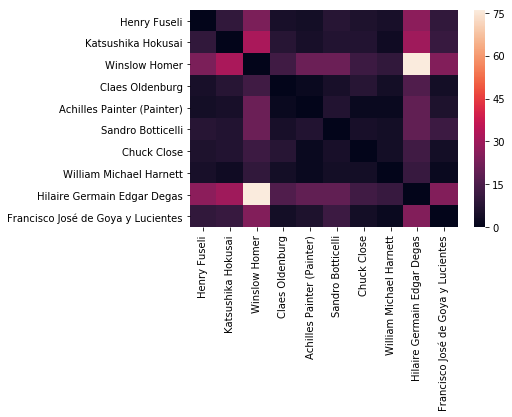

In [583]:
import seaborn as sns
L = []
number1 = 0
for node in g.nodes():
    number1 += 1 
    if number1 >10:
        break
    l = []
    number2 = 0
    for node_ in g.nodes():
        number2 += 1 
        if number2 >10:
            break
        if node == node_:
            l.append(0)
        else:
            try: 
                g.edges[(node, node_)]
                l.append(g.edges[(node, node_)]['weight'])
            except: 
                l.append(0)
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(g.nodes())[:10], index = list(g.nodes())[:10])
ax = sns.heatmap(div)
plt.show()